In [1]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")



Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [2]:
# @title Initialize Config

import torch
import numpy
class Config:
    def __init__(self, **kwargs):
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v4/all_subjects_data_final.h5',
    dataset_root='/content/datasets',
    input_format="csv",
    channels_imu_acc=['ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=[ 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
)

#set seeds
torch.manual_seed(config.seed)
numpy.random.seed(config.seed)


In [3]:
class DataSharder:
    def __init__(self, config, split):
        self.config = config
        self.h5_file_path = config.data_folder_name  # Path to the HDF5 file
        self.split = split

    def load_data(self, subjects, window_length, window_overlap, dataset_name):
        print(f"Processing subjects: {subjects} with window length: {window_length}, overlap: {window_overlap}")

        self.window_length = window_length
        self.window_overlap = window_overlap

        # Process the data from the HDF5 file
        self._process_and_save_patients_h5(subjects, dataset_name)

    def _process_and_save_patients_h5(self, subjects, dataset_name):
        # Open the HDF5 file
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            dataset_folder = os.path.join(self.config.dataset_root, dataset_name, self.split).replace("subject", "").replace("__", "_")
            print("Dataset folder:", dataset_folder)

            if os.path.exists(dataset_folder):
                print("Dataset Exists, Skipping...")
                return

            os.makedirs(dataset_folder, exist_ok=True)
            print("Dataset folder created: ", dataset_folder)

            for subject_id in tqdm(subjects, desc="Processing subjects"):
                subject_key = subject_id
                if subject_key not in h5_file:
                    print(f"Subject {subject_key} not found in the HDF5 file. Skipping.")
                    continue

                subject_data = h5_file[subject_key]
                session_keys = list(subject_data.keys())  # Sessions for this subject

                for session_id in session_keys:
                    session_data_group = subject_data[session_id]

                    for sessions_speed in session_data_group.keys():
                        session_data = session_data_group[sessions_speed]

                        # Extract IMU, EMG, and Joint data as numpy arrays
                        imu_data, imu_columns = self._extract_channel_data(session_data, self.config.channels_imu_acc + self.config.channels_imu_gyr)
                        emg_data, emg_columns = self._extract_channel_data(session_data, self.config.channels_emg)
                        joint_data, joint_columns = self._extract_channel_data(session_data, self.config.channels_joints)

                        # Shard the data into windows and save each window
                        self._save_windowed_data(imu_data, emg_data, joint_data, subject_key, session_id,sessions_speed, dataset_folder, imu_columns, emg_columns, joint_columns)

    def _save_windowed_data(self, imu_data, emg_data, joint_data, subject_key, session_id, session_speed, dataset_folder, imu_columns, emg_columns, joint_columns):
        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        # Path to the CSV log file
        csv_file_path = os.path.join(dataset_folder, '..', f"{self.split}_info.csv")

        # Ensure the folder exists
        os.makedirs(dataset_folder, exist_ok=True)

        # Prepare CSV log headers (ensure the columns are 'file_name' and 'file_path')
        csv_headers = ['file_name', 'file_path']

        # Create or append to the CSV log file
        file_exists = os.path.isfile(csv_file_path)
        with open(csv_file_path, mode='a', newline='') as csv_file:
            writer = csv.writer(csv_file)

            # Write the headers only if the file is new
            if not file_exists:
                writer.writerow(csv_headers)

            # Determine the total data length based on the minimum length across the data sources
            total_data_length = min(imu_data.shape[1], emg_data.shape[1], joint_data.shape[1])

            # Adjust the starting point for windows based on total data length
            start = 2000 if total_data_length > 4000 else 0

            # Ensure that each window across imu_data, emg_data, and joint_data has the same shape before concatenation
            for i in range(start, total_data_length - window_size + 1, step_size):
                imu_window = imu_data[:, i:i + window_size]
                emg_window = emg_data[:, i:i + window_size]
                joint_window = joint_data[:, i:i + window_size]

                # Check if the window sizes are valid
                if imu_window.shape[1] == window_size and emg_window.shape[1] == window_size and joint_window.shape[1] == window_size:
                    # Convert windowed data to pandas DataFrame



                    imu_df = pd.DataFrame(imu_window.T, columns=imu_columns)
                    emg_df = pd.DataFrame(emg_window.T, columns=emg_columns)
                    joint_df = pd.DataFrame(joint_window.T, columns=joint_columns)



                    # Concatenate the data along the column axis
                    combined_df = pd.concat([imu_df, emg_df, joint_df], axis=1)

                    # Save the combined windowed data as a CSV file
                    file_name = f"{subject_key}_{session_id}_{session_speed}_win_{i}_ws{window_size}_ol{overlap}.csv"
                    file_path = os.path.join(dataset_folder, file_name)
                    combined_df.to_csv(file_path, index=False)

                    # Log the file name and path in the CSV (in the correct columns)
                    writer.writerow([file_name, file_path])
                else:
                    print(f"Skipping window {i} due to mismatched window sizes.")

    def _extract_channel_data(self, session_data, channels):
        """
        Extracts data for the given channels from the dataset (whether it's a compound dataset or simple dataset),
        and interpolates missing values (NaNs) in each channel data.
        """
        extracted_data = []
        column_names = []

        if isinstance(session_data, h5py.Dataset):
            # Check if the dataset has named fields (compound dataset)
            if session_data.dtype.names:
                # Compound dataset, use the named fields
                column_names = session_data.dtype.names
                for channel in channels:
                    if channel in column_names:
                        channel_data = session_data[channel][:]  # Access by field name
                        # Convert the data to a numeric type (float), if necessary
                        channel_data = pd.to_numeric(channel_data, errors='coerce')
                        # Interpolate NaN values
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                    else:
                        print(f"Channel {channel} not found in compound dataset.")
            else:
                # Simple dataset, use index-based access (no named fields)
                column_names = session_data.attrs.get('column_names', [])

                # Cast column_names to a list to allow 'index' lookup
                column_names = list(column_names)
                new_column_names = []

                assert len(column_names) > 0, "column_names not found in dataset attributes"
                for channel in channels:
                    if channel in column_names:
                        col_idx = column_names.index(channel)
                        new_column_names.append(channel)
                        channel_data = session_data[:, col_idx]  # Access by column index

                        # Convert the data to a numeric type (float), if necessary
                        channel_data = pd.to_numeric(channel_data, errors='coerce')

                        # Interpolate NaN values
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                    else:
                        print(f"Channel {channel} not found in session data.")

        return np.array(extracted_data), new_column_names

In [4]:
# @title Dataset creation
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch.utils.data import ConcatDataset
import random
from torch.utils.data import TensorDataset

class ImuJointPairDataset(Dataset):
    def __init__(self, config, subjects, window_length, window_overlap, split='train', dataset_train_name='train', dataset_test_name='test'):
        self.config = config
        self.split = split
        self.subjects = subjects
        self.window_length = window_length
        self.window_overlap = window_overlap if split == 'train' else 0
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        # Convert the list of subjects to a string that is path-safe
        subjects_str = "_".join(map(str, subjects)).replace('subject', '').replace('__', '_')

        # Use dataset_train_name or dataset_test_name based on split
        if split == 'train':
            dataset_name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{subjects_str}"
        else:
            dataset_name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_test{subjects_str}"

        self.dataset_name = dataset_name

        # Define the root directory based on dataset name
        self.root_dir = os.path.join(self.config.dataset_root, self.dataset_name)

        # Ensure sharded data exists, if not, reshard
        self.ensure_resharded(subjects, dataset_train_name if split == 'train' else dataset_test_name)

        info_path = os.path.join(self.root_dir, f"{split}_info.csv")
        self.data = pd.read_csv(info_path)

    def ensure_resharded(self, subjects, dataset_name):
        if not os.path.exists(self.root_dir):
            print(f"Sharded data not found at {self.root_dir}. Resharding...")
            data_sharder = DataSharder(self.config,self.split)
            # Pass dynamic parameters to sharder
            data_sharder.load_data(subjects, window_length=self.window_length, window_overlap=self.window_overlap, dataset_name=self.dataset_name)
        else:
            print(f"Sharded data found at {self.root_dir}. Skipping resharding.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir,self.split, self.data.iloc[idx, 0])

        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        return torch.tensor(data, dtype=torch.float32)

class ImuJointPairSubjectDataset(ImuJointPairDataset):
    def __init__(self, config, subjects, window_length, window_overlap, split='train', dataset_train_name='train', dataset_test_name='test'):
        super().__init__(config, subjects, window_length, window_overlap, split, dataset_train_name, dataset_test_name)

        # Create a mapping from subject strings (e.g., 'subject_1') to class indices
        self.subject_mapping = {subject: i for i, subject in enumerate(sorted(subjects))}

    def __getitem__(self, idx):
        # Retrieve the original data from the parent class
        imu_data_acc, imu_data_gyr, joint_data, emg_data = super().__getitem__(idx)

        # Get the filename from the data index
        filename = self.data.iloc[idx, 0]

        # Extract the subject ID from the filename
        filename_base = os.path.basename(filename)
        filename_without_ext = os.path.splitext(filename_base)[0]
        parts = filename_without_ext.split('_')

        # Construct subject string in the format 'subject_x'
        try:
            subject_index = parts.index('subject')
            subject_str = f"subject_{parts[subject_index + 1]}"  # Create string like 'subject_1'
        except ValueError:
            raise ValueError(f"'subject' not found in filename: {filename}")
        except IndexError:
            raise ValueError(f"Subject ID not found after 'subject' in filename: {filename}")

        # Map subject_str to class index
        if subject_str not in self.subject_mapping:
            raise ValueError(f"Subject ID {subject_str} not found in training set.")

        mapped_class = self.subject_mapping[subject_str]

        # Return class index instead of one-hot encoding
        return imu_data_acc, imu_data_gyr, joint_data, emg_data, mapped_class


def create_base_data_loaders(
    config,
    train_subjects,
    test_subjects,
    window_length=100,
    window_overlap=75,
    batch_size=64,
    dataset_train_name='train',
    dataset_test_name='test'
):
    # Create datasets with explicit parameters
    train_dataset = ImuJointPairSubjectDataset(
        config=config,
        subjects=train_subjects,
        window_length=window_length,
        window_overlap=window_overlap,
        split='train',
        dataset_train_name=dataset_train_name
    )

    test_dataset = ImuJointPairSubjectDataset(
        config=config,
        subjects=test_subjects,
        window_length=window_length,
        window_overlap=0,  # Typically no overlap in test set
        split='test',
        dataset_test_name=dataset_test_name
    )

    # Split train dataset into training and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader




In [5]:
# @title Kinematicsnet Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error
import numpy as np
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        out_1, (h_1, _) = self.lstm_1(x)
        out_1 = self.dropout_1(out_1)
        out_2, (h_2, _) = self.lstm_2(out_1)
        out_2 = self.dropout_2(out_2)
        return out_2, (h_1, h_2)

class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.gru_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0)
        self.gru_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        out_1, h_1 = self.gru_1(x)
        out_1 = self.dropout_1(out_1)
        out_2, h_2 = self.gru_2(out_1)
        out_2 = self.dropout_2(out_2)
        return out_2, (h_1, h_2)


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used


from torch.autograd import Function

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_grl):
        ctx.lambda_grl = lambda_grl
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        lambda_grl = ctx.lambda_grl
        grad_input = grad_output.neg() * lambda_grl
        return grad_input, None

def GradientReversalLayer(lambda_grl):
    return GradientReversalFunction.apply

class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100,num_subjects=12,lambda_grl=1.0):
        super(teacher, self).__init__()

        self.lambda_grl = lambda_grl
        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.fc_classifier = nn.Linear(2*3*128+128,num_subjects)
        self.dropout=nn.Dropout(p=.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        # Pass through Encoder 1 for each modality and capture hidden states
        x_acc_1, (h_acc_1, _) = self.encoder_1_acc(x_acc_2)
        x_gyr_1, (h_gyr_1, _) = self.encoder_1_gyr(x_gyr_2)
        x_emg_1, (h_emg_1, _) = self.encoder_1_emg(x_emg_2)

        # Pass through Encoder 2 for each modality and capture hidden states
        x_acc_2, (h_acc_2, _) = self.encoder_2_acc(x_acc_2)
        x_gyr_2, (h_gyr_2, _) = self.encoder_2_gyr(x_gyr_2)
        x_emg_2, (h_emg_2, _) = self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        #print shape of out
        out_task=self.fc(out)

        grl = GradientReversalLayer(self.lambda_grl)
        out_rev = grl(out, self.lambda_grl)  # Apply GRL to reverse gradients

        # Domain classification with reversed gradients
        out_rev = out_rev.permute(0, 2, 1)  # Permute to [batch_size, features, time]
        out_rev = torch.nn.functional.adaptive_avg_pool1d(out_rev, 1)  # Pooling
        out_rev = out_rev.squeeze(-1)  # Shape: [batch_size, features]

        out_classifier = self.fc_classifier(out_rev)  # Domain classifier output


        #print(out.shape)
        return out_task, out_classifier, (h_acc_1, h_acc_2, h_gyr_1, h_gyr_2, h_emg_1, h_emg_2)




In [6]:
# @title Loss Functions
import statistics

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss

#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim,print_losses=True):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))





  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]




              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)


  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)


  if print_losses:
    print(rmse_1)
    print(rmse_2)
    print(rmse_3)
    print("\n")
    print(p_1)
    print(p_2)
    print(p_3)
    print('Mean: %.3f' % m,'+/- %.3f' %SD)
    print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)

  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7

def compute_biomechanical_loss(predicted_angles):
    """
    Compute the biomechanical loss (L_bio) to enforce joint limits
    for the three joints, using index-based access.
    """
    # Define joint limits for each channel (in degrees)
    min_limits = torch.tensor([0, -90, -120], device=predicted_angles.device)
    max_limits = torch.tensor([150, 180, 90], device=predicted_angles.device)

    while min_limits.dim() < predicted_angles.dim():
        min_limits = min_limits.unsqueeze(0)
    while max_limits.dim() < predicted_angles.dim():
        max_limits = max_limits.unsqueeze(0)

    # Now min_limits and max_limits have shape [1, 1, num_joints] and will broadcast correctly
    lower_violation = torch.relu(min_limits - predicted_angles)
    upper_violation = torch.relu(predicted_angles - max_limits)

    L_bio = torch.mean(lower_violation + upper_violation)

    return L_bio


class BoundRmseLoss(nn.Module):
    def __init__(self, lambda_bio=0.1):
        super(BoundRmseLoss, self).__init__()
        self.lambda_bio = lambda_bio
        self.rmse_loss = RMSELoss()  # Using your existing RMSELoss class

    def forward(self, output, target):
        # Compute RMSE loss
        L_data = self.rmse_loss(output, target)

        # Compute biomechanical loss
        L_bio = compute_biomechanical_loss(output)

        # Total loss
        total_loss = L_data + self.lambda_bio * L_bio

        return total_loss

In [7]:
# @title Model Utils

# Evaluation function
def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = 0.0
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG,_) in enumerate(loader):
            output= model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())

            if isinstance(model, teacher):
                output,knowledge_distillation,_ = output
                loss = criterion(output, target.to(device).float())
            else:
                loss = criterion(output, target.to(device).float())

            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            total_loss += loss.item()
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse



def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None,
                    channelwise_metrics=None, history=None, curriculum_schedule=None):

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }

    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']

    # Save the history (losses, PCCs, RMSEs, channel-wise metrics)
    if history:
        checkpoint['history'] = history

    # Save curriculum schedule
    if curriculum_schedule:
        checkpoint['curriculum_schedule'] = curriculum_schedule

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")



def train_teacher(
    device,
    train_loader,
    val_loader,
    test_loader,
    learn_rate,
    epochs,
    model,
    filename,
    loss_function,
    optimizer=None,
    l1_lambda=None,
    train_from_last_epoch=False,
    curriculum_loader=None,
    num_classes=12,  # Add num_classes parameter
    alpha=1.0,       # Weighting factor for classification loss
):
    model.to(device)
    criterion_regression = loss_function
    criterion_classification = nn.CrossEntropyLoss(ignore_index=-1)

    if optimizer is None:
        # Create a default Adam optimizer if none is passed
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    train_pccs_channelwise = []
    val_pccs_channelwise = []
    test_pccs_channelwise = []

    train_rmses_channelwise = []
    val_rmses_channelwise = []
    test_rmses_channelwise = []

    # Check for existing checkpoint to resume training
    last_epoch = 0
    checkpoint_path = f"/content/MyDrive/MyDrive/models/{filename}/"

    if train_from_last_epoch and os.path.exists(checkpoint_path):
        # Scan for the latest saved checkpoint
        checkpoints = [f for f in os.listdir(checkpoint_path) if f.endswith('.pth')]
        if checkpoints:
            checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort by epoch number
            latest_checkpoint = checkpoints[-1]
            print(f"Loading model from checkpoint: {latest_checkpoint}")
            checkpoint = torch.load(os.path.join(checkpoint_path, latest_checkpoint))
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            last_epoch = checkpoint['epoch']  # Continue from the next epoch

            # Load the history from checkpoint
            train_losses = checkpoint['history']['train_losses']
            val_losses = checkpoint['history']['val_losses']
            test_losses = checkpoint['history']['test_losses']
            train_pccs = checkpoint['history']['train_pccs']
            val_pccs = checkpoint['history']['val_pccs']
            test_pccs = checkpoint['history']['test_pccs']
            train_rmses = checkpoint['history']['train_rmses']
            val_rmses = checkpoint['history']['val_rmses']
            test_rmses = checkpoint['history']['test_rmses']
            train_pccs_channelwise = checkpoint['history']['train_pccs_channelwise']
            val_pccs_channelwise = checkpoint['history']['val_pccs_channelwise']
            test_pccs_channelwise = checkpoint['history']['test_pccs_channelwise']
            train_rmses_channelwise = checkpoint['history']['train_rmses_channelwise']
            val_rmses_channelwise = checkpoint['history']['val_rmses_channelwise']
            test_rmses_channelwise = checkpoint['history']['test_rmses_channelwise']
            if 'curriculum_schedule' in checkpoint:
                curriculum_loader.curriculum_schedule = checkpoint['curriculum_schedule']  # Load saved curriculum schedule
        else:
            print("No checkpoints found, starting from scratch.")
    else:
        print("Starting from scratch.")

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(last_epoch, epochs):
        epoch_start_time = time.time()
        model.train()

        if curriculum_loader:
            curriculum_loader.update_epoch(epoch)
            train_loader, val_loader, test_loader = curriculum_loader.get_loaders()

        # Track total loss
        epoch_train_total_loss = 0.0
        epoch_train_regression_loss = 0.0
        epoch_train_classification_loss = 0.0

        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG, subject_id) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()

            #print dimensions of each and subject id
            # print("acc",data_acc.shape)
            # print("gyro",data_gyr.shape)
            # print("target",target.shape)
            # print("emg",data_EMG.shape)
            # print("subject ids",subject_id)

            # Move data to device
            data_acc = data_acc.to(device).float()
            data_gyr = data_gyr.to(device).float()
            data_EMG = data_EMG.to(device).float()
            target = target.to(device).float()
            subject_id = subject_id.to(device).long() - 1  # Adjust subject IDs to start from 0

            # Forward pass
            output, out_classifier, _ = model(data_acc, data_gyr, data_EMG)

            # print(f"Output shape: {output.shape}")
            # print(f"Target shape: {target.shape}")
            # Compute regression loss
            loss_regression = criterion_regression(output, target)

            # Compute classification loss
            # Ensure shapes are correct
            # print(f"Out Classifier shape: {out_classifier.shape}")
            # print(f"Subject ID shape: {subject_id.shape}")
            # print(f"Subject ID dtype: {subject_id.dtype}")
            # print(f"Out Classifier dtype: {out_classifier.dtype}")
            # print(f"subject ids",subject_id)
            # print(f"out classifier",out_classifier)
            loss_classification = criterion_classification(out_classifier, subject_id)

            # Combine losses
            total_loss = loss_regression + alpha * loss_classification

            # Apply L1 regularization if specified
            if l1_lambda is not None:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                total_loss += l1_lambda * l1_norm

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()



            # Detach tensors and move to CPU to prevent issues with gradient computation
            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(
                output.detach().cpu().numpy(),
                target.detach().cpu().numpy(),
                len(config.channels_joints),
                print_losses=False
            )

            # Update metrics
            epoch_train_total_loss += total_loss.item()
            epoch_train_regression_loss += loss_regression.item()
            epoch_train_classification_loss += loss_classification.item()

            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        # Calculate average losses
        avg_train_total_loss = epoch_train_total_loss / len(train_loader)
        avg_train_regression_loss = epoch_train_regression_loss / len(train_loader)
        avg_train_classification_loss = epoch_train_classification_loss / len(train_loader)

        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_total_loss)
        train_pccs.append(np.mean(avg_train_pcc))  # Overall average PCC
        train_rmses.append(np.mean(avg_train_rmse))  # Overall average RMSE

        # Save channel-wise metrics
        train_pccs_channelwise.append(avg_train_pcc)  # Per channel
        train_rmses_channelwise.append(avg_train_rmse)  # Per channel

        # Evaluate on validation set
        avg_val_total_loss, avg_val_pcc, avg_val_rmse = evaluate_model(
            device,
            model,
            val_loader,
            criterion_regression
        )

        val_losses.append(avg_val_total_loss)
        val_pccs.append(np.mean(avg_val_pcc))  # Overall average PCC
        val_rmses.append(np.mean(avg_val_rmse))  # Overall average RMSE

        # Save channel-wise metrics
        val_pccs_channelwise.append(avg_val_pcc)  # Per channel
        val_rmses_channelwise.append(avg_val_rmse)  # Per channel

        # Evaluate on test set
        avg_test_total_loss, avg_test_pcc, avg_test_rmse = evaluate_model(
            device,
            model,
            test_loader,
            criterion_regression
        )

        test_losses.append(avg_test_total_loss)
        test_pccs.append(np.mean(avg_test_pcc))  # Overall average PCC
        test_rmses.append(np.mean(avg_test_rmse))  # Overall average RMSE

        # Save channel-wise metrics
        test_pccs_channelwise.append(avg_test_pcc)  # Per channel
        test_rmses_channelwise.append(avg_test_rmse)  # Per channel

        print(f"Epoch: {epoch + 1}, Training Total Loss: {avg_train_total_loss:.4f}, Validation Total Loss: {avg_val_total_loss:.4f}, Test Total Loss: {avg_test_total_loss:.4f}")
        print(f"Training Regression Loss: {avg_train_regression_loss:.4f}, Validation Regression Loss: {avg_val_total_loss:.4f}, Test Regression Loss: {avg_test_total_loss:.4f}")
        print(f"Training Classification Loss: {avg_train_classification_loss:.4f}, Validation Classification Loss: {avg_val_total_loss:.4f}, Test Classification Loss: {avg_test_total_loss:.4f}")
        print(f"Training RMSE: {np.mean(avg_train_rmse):.4f}, Validation RMSE: {np.mean(avg_val_rmse):.4f}, Test RMSE: {np.mean(avg_test_rmse):.4f}")
        print(f"Training PCC: {np.mean(avg_train_pcc):.4f}, Validation PCC: {np.mean(avg_val_pcc):.4f}, Test PCC: {np.mean(avg_test_pcc):.4f}")

        # Save checkpoint, including curriculum schedule
        if not os.path.exists(checkpoint_path):
            os.makedirs(checkpoint_path)

        # Save checkpoint with the curriculum schedule
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_losses': test_losses,
            'train_pccs': train_pccs,
            'val_pccs': val_pccs,
            'test_pccs': test_pccs,
            'train_rmses': train_rmses,
            'val_rmses': val_rmses,
            'test_rmses': test_rmses,
            'train_pccs_channelwise': train_pccs_channelwise,
            'val_pccs_channelwise': val_pccs_channelwise,
            'test_pccs_channelwise': test_pccs_channelwise,
            'train_rmses_channelwise': train_rmses_channelwise,
            'val_rmses_channelwise': val_rmses_channelwise,
            'test_rmses_channelwise': test_rmses_channelwise
        }

        save_checkpoint(
            model,
            optimizer,
            epoch,
            f"{checkpoint_path}/{filename}_epoch_{epoch + 1}.pth",
            train_loss=avg_train_total_loss,
            val_loss=avg_val_total_loss,
            test_loss=avg_test_total_loss,
            channelwise_metrics={
                'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
            },
            history=history,  # Save history in the checkpoint
            curriculum_schedule=curriculum_loader.curriculum_schedule if curriculum_loader else None  # Save curriculum schedule
        )

        # Early stopping logic
        if avg_val_total_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses







In [8]:
# @title Helper Functions


# Function to create the teacher model with defaults from config
def create_teacher_model(input_acc, input_gyr, input_emg, base_weights_path=None, drop_prob=0.25, w=100,num_subjects=None):
    model = teacher(input_acc, input_gyr, input_emg, drop_prob=drop_prob, w=w,num_subjects=num_subjects)

    if base_weights_path:
        # Load the initial weights from the base model
        model.load_state_dict(torch.load(base_weights_path))

    return model


In [9]:

import os
import h5py
import csv
from tqdm.notebook import tqdm
import pandas as pd
def create_curriculum_schedule(all_subjects, num_subjects, epochs):
    return [(epoch, sorted(random.sample(all_subjects, num_subjects))) for epoch in range(epochs)]

# Define the list of all subjects
all_subjects = ['subject_1','subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6',
                'subject_7', 'subject_8', 'subject_9', 'subject_10',
                'subject_11', 'subject_12', 'subject_13']

# Define the base model and save its weights
input_acc, input_gyr, input_emg = 15, 15, 3
window_overlap = 75
batch_size = 64
curriculum_epochs = 10

# Create model configurations for each subject as the test subject
model_configs = {}

test_subject = 'subject_1'

# Define the number of subjects/classes
num_classes = 12

# List of different weights for the classification loss
alpha = .1


for test_subject in all_subjects:

    train_subjects = [subject for subject in all_subjects if subject not in test_subject]
    model_name = f'TeacherModel_DomainInvariant_{test_subject}_alpha_{alpha}_wl{100}_ol{75}_nohandimu'
    model_configs[model_name] = {
        'model': create_teacher_model(
            input_acc=input_acc,
            input_gyr=input_gyr,
            input_emg=input_emg,
            w=100,
            num_subjects=num_classes  # Ensure the model includes the classification head
        ),
        'loss': RMSELoss(),
        'loaders': create_base_data_loaders(
            config=config,
            train_subjects=train_subjects,
            test_subjects=[test_subject],
            window_length=100,
            window_overlap=75,
            batch_size=batch_size
        ),
        'epochs': curriculum_epochs,
        'use_curriculum': False,
        'alpha': alpha,  # Weighting factor for classification loss
        'num_classes': num_classes,  # Number of classes for the classification task,
        'train_from_last_epoch': False,
    }

# Output the model configurations for debugging (optional)
for model_name, model_conf in model_configs.items():
    print(f"Model: {model_name}")


Sharded data found at /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol0_test_1. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol75_train_1_3_4_5_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol0_test_2. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol75_train_1_2_4_5_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol0_test_3. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol75_train_1_2_3_5_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol0_test_4. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol0_test_5. Skipping re

In [10]:
 # @title run models

#clear gpu memory
torch.cuda.empty_cache()

def ask_run():
    response = input("Do you want to run models? (yes/no): ").strip().lower()
    if response in ['yes', 'y']:
        return True
    elif response in ['no', 'n']:
        return False
    else:
        print("Invalid input. Please enter 'yes' or 'no'.")
        return ask_run()  # Recursively ask again until valid input is given

# run = ask_run()
run = True
if run:
    for model_name, model_config in model_configs.items():
        model = model_config['model']
        loss_function = model_config['loss']  # May be None, as loss functions are defined within train_teacher
        epochs = model_config.get("epochs", 100)
        device = model_config.get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        learn_rate = model_config.get("learn_rate", 0.001)
        use_curriculum = model_config.get("use_curriculum", False)

        optimizer = model_config.get("optimizer", None)
        l1_lambda = model_config.get("l1_lambda", None)
        alpha = model_config.get('alpha', 1.0)
        num_classes = model_config.get('num_classes', 12)  # Default to 12 if not specified

        print(f"Running model: {model_name} with alpha: {alpha}")

        if use_curriculum:
            curriculum_loader = model_config['loader']  # Get the CurriculumDataLoader
            train_loader, val_loader, test_loader = None, None, None  # Curriculum will handle loading per epoch

            model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, \
            train_rmses, val_rmses, test_rmses = train_teacher(
                device=device,
                train_loader=train_loader,  # Placeholders; curriculum will manage loaders dynamically
                val_loader=val_loader,
                test_loader=test_loader,
                learn_rate=learn_rate,
                epochs=epochs,
                model=model,
                filename=model_name,
                loss_function=loss_function,
                curriculum_loader=curriculum_loader,  # Pass the curriculum loader here
                optimizer=optimizer,
                l1_lambda=l1_lambda,
                train_from_last_epoch=model_config.get("train_from_last_epoch", False),
                alpha=alpha,
                num_classes=num_classes,
            )
        else:
            # Unpack the static loaders tuple (train_loader, val_loader, test_loader)
            train_loader, val_loader, test_loader = model_config['loaders']

            model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, \
            train_rmses, val_rmses, test_rmses = train_teacher(
                device=device,
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                learn_rate=learn_rate,
                epochs=epochs,
                model=model,
                filename=model_name,
                loss_function=loss_function,
                optimizer=optimizer,
                l1_lambda=l1_lambda,
                train_from_last_epoch=model_config.get("train_from_last_epoch", False),
                alpha=alpha,
                num_classes=num_classes,
            )

        print(f"Finished training for {model_name}.")


Running model: TeacherModel_DomainInvariant_subject_1_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.6709, Validation Total Loss: 11.6741, Test Total Loss: 18.0348
Training Regression Loss: 18.4309, Validation Regression Loss: 11.6741, Test Regression Loss: 18.0348
Training Classification Loss: 2.3999, Validation Classification Loss: 11.6741, Test Classification Loss: 18.0348
Training RMSE: 17.9684, Validation RMSE: 11.1621, Test RMSE: 16.9576
Training PCC: 0.7789, Validation PCC: 0.9366, Test PCC: 0.6748
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 10.9804, Validation Total Loss: 9.0422, Test Total Loss: 19.0254
Training Regression Loss: 10.7836, Validation Regression Loss: 9.0422, Test Regression Loss: 19.0254
Training Classification Loss: 1.9679, Validation Classification Loss: 9.0422, Test Classification Loss: 19.0254
Training RMSE: 10.3811, Validation RMSE: 8.6720, Test RMSE: 18.1198
Training PCC: 0.9465, Validation PCC: 0.9622, Test PCC: 0.7036
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.4491, Validation Total Loss: 8.6573, Test Total Loss: 19.3066
Training Regression Loss: 9.2665, Validation Regression Loss: 8.6573, Test Regression Loss: 19.3066
Training Classification Loss: 1.8259, Validation Classification Loss: 8.6573, Test Classification Loss: 19.3066
Training RMSE: 8.8947, Validation RMSE: 8.2155, Test RMSE: 18.2684
Training PCC: 0.9619, Validation PCC: 0.9678, Test PCC: 0.6915
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.6454, Validation Total Loss: 7.7223, Test Total Loss: 18.8872
Training Regression Loss: 8.4556, Validation Regression Loss: 7.7223, Test Regression Loss: 18.8872
Training Classification Loss: 1.8981, Validation Classification Loss: 7.7223, Test Classification Loss: 18.8872
Training RMSE: 8.0864, Validation RMSE: 7.3718, Test RMSE: 18.0239
Training PCC: 0.9685, Validation PCC: 0.9746, Test PCC: 0.6918
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.2580, Validation Total Loss: 7.6230, Test Total Loss: 19.9253
Training Regression Loss: 8.0590, Validation Regression Loss: 7.6230, Test Regression Loss: 19.9253
Training Classification Loss: 1.9899, Validation Classification Loss: 7.6230, Test Classification Loss: 19.9253
Training RMSE: 7.7248, Validation RMSE: 7.3015, Test RMSE: 19.1855
Training PCC: 0.9715, Validation PCC: 0.9761, Test PCC: 0.7077
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.7475, Validation Total Loss: 6.8972, Test Total Loss: 19.3884
Training Regression Loss: 7.5406, Validation Regression Loss: 6.8972, Test Regression Loss: 19.3884
Training Classification Loss: 2.0684, Validation Classification Loss: 6.8972, Test Classification Loss: 19.3884
Training RMSE: 7.2344, Validation RMSE: 6.5703, Test RMSE: 18.6154
Training PCC: 0.9747, Validation PCC: 0.9782, Test PCC: 0.6896
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.4794, Validation Total Loss: 6.8045, Test Total Loss: 20.1454
Training Regression Loss: 7.2658, Validation Regression Loss: 6.8045, Test Regression Loss: 20.1454
Training Classification Loss: 2.1356, Validation Classification Loss: 6.8045, Test Classification Loss: 20.1454
Training RMSE: 6.9603, Validation RMSE: 6.5528, Test RMSE: 19.1350
Training PCC: 0.9765, Validation PCC: 0.9795, Test PCC: 0.6910
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.3252, Validation Total Loss: 6.6788, Test Total Loss: 18.2954
Training Regression Loss: 7.1077, Validation Regression Loss: 6.6788, Test Regression Loss: 18.2954
Training Classification Loss: 2.1751, Validation Classification Loss: 6.6788, Test Classification Loss: 18.2954
Training RMSE: 6.8148, Validation RMSE: 6.3150, Test RMSE: 17.4084
Training PCC: 0.9776, Validation PCC: 0.9801, Test PCC: 0.7109
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.0514, Validation Total Loss: 6.8349, Test Total Loss: 19.7014
Training Regression Loss: 6.8266, Validation Regression Loss: 6.8349, Test Regression Loss: 19.7014
Training Classification Loss: 2.2478, Validation Classification Loss: 6.8349, Test Classification Loss: 19.7014
Training RMSE: 6.5581, Validation RMSE: 6.6325, Test RMSE: 18.7459
Training PCC: 0.9790, Validation PCC: 0.9818, Test PCC: 0.7035
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.8157, Validation Total Loss: 6.1229, Test Total Loss: 19.2904
Training Regression Loss: 6.5800, Validation Regression Loss: 6.1229, Test Regression Loss: 19.2904
Training Classification Loss: 2.3570, Validation Classification Loss: 6.1229, Test Classification Loss: 19.2904
Training RMSE: 6.3286, Validation RMSE: 5.8301, Test RMSE: 18.3003
Training PCC: 0.9803, Validation PCC: 0.9832, Test PCC: 0.7194
Checkpoint saved for epoch 10
Total training time: 1435.16 seconds
Finished training for TeacherModel_DomainInvariant_subject_1_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_2_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 17.9240, Validation Total Loss: 9.6750, Test Total Loss: 22.0766
Training Regression Loss: 17.6913, Validation Regression Loss: 9.6750, Test Regression Loss: 22.0766
Training Classification Loss: 2.3269, Validation Classification Loss: 9.6750, Test Classification Loss: 22.0766
Training RMSE: 17.2543, Validation RMSE: 9.4305, Test RMSE: 20.3359
Training PCC: 0.7848, Validation PCC: 0.9461, Test PCC: 0.6828
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 9.6493, Validation Total Loss: 7.6381, Test Total Loss: 21.6062
Training Regression Loss: 9.4701, Validation Regression Loss: 7.6381, Test Regression Loss: 21.6062
Training Classification Loss: 1.7917, Validation Classification Loss: 7.6381, Test Classification Loss: 21.6062
Training RMSE: 9.1761, Validation RMSE: 7.3206, Test RMSE: 20.1493
Training PCC: 0.9556, Validation PCC: 0.9705, Test PCC: 0.6929
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 8.0907, Validation Total Loss: 6.5003, Test Total Loss: 22.3631
Training Regression Loss: 7.9245, Validation Regression Loss: 6.5003, Test Regression Loss: 22.3631
Training Classification Loss: 1.6625, Validation Classification Loss: 6.5003, Test Classification Loss: 22.3631
Training RMSE: 7.6171, Validation RMSE: 6.2257, Test RMSE: 20.8938
Training PCC: 0.9700, Validation PCC: 0.9773, Test PCC: 0.6835
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 7.4865, Validation Total Loss: 6.3413, Test Total Loss: 21.8508
Training Regression Loss: 7.3180, Validation Regression Loss: 6.3413, Test Regression Loss: 21.8508
Training Classification Loss: 1.6858, Validation Classification Loss: 6.3413, Test Classification Loss: 21.8508
Training RMSE: 7.0048, Validation RMSE: 6.0668, Test RMSE: 20.3988
Training PCC: 0.9755, Validation PCC: 0.9802, Test PCC: 0.6918
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 7.0413, Validation Total Loss: 5.9751, Test Total Loss: 22.0745
Training Regression Loss: 6.8641, Validation Regression Loss: 5.9751, Test Regression Loss: 22.0745
Training Classification Loss: 1.7720, Validation Classification Loss: 5.9751, Test Classification Loss: 22.0745
Training RMSE: 6.5520, Validation RMSE: 5.6446, Test RMSE: 20.4928
Training PCC: 0.9783, Validation PCC: 0.9822, Test PCC: 0.6905
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 6.8033, Validation Total Loss: 5.8960, Test Total Loss: 22.0450
Training Regression Loss: 6.6120, Validation Regression Loss: 5.8960, Test Regression Loss: 22.0450
Training Classification Loss: 1.9122, Validation Classification Loss: 5.8960, Test Classification Loss: 22.0450
Training RMSE: 6.3131, Validation RMSE: 5.6382, Test RMSE: 20.3808
Training PCC: 0.9800, Validation PCC: 0.9823, Test PCC: 0.6939
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 6.5404, Validation Total Loss: 5.7497, Test Total Loss: 22.6770
Training Regression Loss: 6.3372, Validation Regression Loss: 5.7497, Test Regression Loss: 22.6770
Training Classification Loss: 2.0322, Validation Classification Loss: 5.7497, Test Classification Loss: 22.6770
Training RMSE: 6.0522, Validation RMSE: 5.5534, Test RMSE: 21.3197
Training PCC: 0.9812, Validation PCC: 0.9841, Test PCC: 0.6823
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 6.3064, Validation Total Loss: 5.4646, Test Total Loss: 22.1138
Training Regression Loss: 6.0867, Validation Regression Loss: 5.4646, Test Regression Loss: 22.1138
Training Classification Loss: 2.1964, Validation Classification Loss: 5.4646, Test Classification Loss: 22.1138
Training RMSE: 5.7997, Validation RMSE: 5.1300, Test RMSE: 20.5400
Training PCC: 0.9830, Validation PCC: 0.9860, Test PCC: 0.6953
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 6.1360, Validation Total Loss: 5.3598, Test Total Loss: 21.7649
Training Regression Loss: 5.9031, Validation Regression Loss: 5.3598, Test Regression Loss: 21.7649
Training Classification Loss: 2.3292, Validation Classification Loss: 5.3598, Test Classification Loss: 21.7649
Training RMSE: 5.6174, Validation RMSE: 5.0662, Test RMSE: 20.1680
Training PCC: 0.9840, Validation PCC: 0.9861, Test PCC: 0.6921
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.0191, Validation Total Loss: 4.9842, Test Total Loss: 21.6549
Training Regression Loss: 5.7860, Validation Regression Loss: 4.9842, Test Regression Loss: 21.6549
Training Classification Loss: 2.3311, Validation Classification Loss: 4.9842, Test Classification Loss: 21.6549
Training RMSE: 5.5118, Validation RMSE: 4.7394, Test RMSE: 19.9645
Training PCC: 0.9847, Validation PCC: 0.9873, Test PCC: 0.6988
Checkpoint saved for epoch 10
Total training time: 1383.76 seconds
Finished training for TeacherModel_DomainInvariant_subject_2_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_3_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 17.8205, Validation Total Loss: 10.9389, Test Total Loss: 20.8711
Training Regression Loss: 17.5871, Validation Regression Loss: 10.9389, Test Regression Loss: 20.8711
Training Classification Loss: 2.3332, Validation Classification Loss: 10.9389, Test Classification Loss: 20.8711
Training RMSE: 17.1925, Validation RMSE: 10.5964, Test RMSE: 18.7861
Training PCC: 0.7875, Validation PCC: 0.9379, Test PCC: 0.7168
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 10.2692, Validation Total Loss: 9.1071, Test Total Loss: 21.0988
Training Regression Loss: 10.0866, Validation Regression Loss: 9.1071, Test Regression Loss: 21.0988
Training Classification Loss: 1.8257, Validation Classification Loss: 9.1071, Test Classification Loss: 21.0988
Training RMSE: 9.8251, Validation RMSE: 8.7606, Test RMSE: 19.3964
Training PCC: 0.9503, Validation PCC: 0.9630, Test PCC: 0.7435
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 8.9874, Validation Total Loss: 7.9120, Test Total Loss: 20.0911
Training Regression Loss: 8.8171, Validation Regression Loss: 7.9120, Test Regression Loss: 20.0911
Training Classification Loss: 1.7031, Validation Classification Loss: 7.9120, Test Classification Loss: 20.0911
Training RMSE: 8.5382, Validation RMSE: 7.6252, Test RMSE: 18.1488
Training PCC: 0.9638, Validation PCC: 0.9697, Test PCC: 0.7553
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.1417, Validation Total Loss: 7.4036, Test Total Loss: 20.3060
Training Regression Loss: 7.9659, Validation Regression Loss: 7.4036, Test Regression Loss: 20.3060
Training Classification Loss: 1.7572, Validation Classification Loss: 7.4036, Test Classification Loss: 20.3060
Training RMSE: 7.7134, Validation RMSE: 7.1190, Test RMSE: 18.4929
Training PCC: 0.9703, Validation PCC: 0.9726, Test PCC: 0.7470
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 7.5732, Validation Total Loss: 6.9078, Test Total Loss: 18.1000
Training Regression Loss: 7.3773, Validation Regression Loss: 6.9078, Test Regression Loss: 18.1000
Training Classification Loss: 1.9581, Validation Classification Loss: 6.9078, Test Classification Loss: 18.1000
Training RMSE: 7.1435, Validation RMSE: 6.5928, Test RMSE: 16.1778
Training PCC: 0.9739, Validation PCC: 0.9775, Test PCC: 0.7533
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.4618, Validation Total Loss: 6.6720, Test Total Loss: 18.9868
Training Regression Loss: 7.2497, Validation Regression Loss: 6.6720, Test Regression Loss: 18.9868
Training Classification Loss: 2.1208, Validation Classification Loss: 6.6720, Test Classification Loss: 18.9868
Training RMSE: 7.0276, Validation RMSE: 6.4359, Test RMSE: 16.9393
Training PCC: 0.9751, Validation PCC: 0.9780, Test PCC: 0.7434
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.1905, Validation Total Loss: 6.5179, Test Total Loss: 20.4337
Training Regression Loss: 6.9805, Validation Regression Loss: 6.5179, Test Regression Loss: 20.4337
Training Classification Loss: 2.1001, Validation Classification Loss: 6.5179, Test Classification Loss: 20.4337
Training RMSE: 6.7661, Validation RMSE: 6.2758, Test RMSE: 18.4606
Training PCC: 0.9773, Validation PCC: 0.9800, Test PCC: 0.7519
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 6.7321, Validation Total Loss: 6.5166, Test Total Loss: 18.5940
Training Regression Loss: 6.5148, Validation Regression Loss: 6.5166, Test Regression Loss: 18.5940
Training Classification Loss: 2.1727, Validation Classification Loss: 6.5166, Test Classification Loss: 18.5940
Training RMSE: 6.3264, Validation RMSE: 6.2680, Test RMSE: 16.7842
Training PCC: 0.9794, Validation PCC: 0.9799, Test PCC: 0.7547
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 6.6080, Validation Total Loss: 6.0954, Test Total Loss: 19.1444
Training Regression Loss: 6.3838, Validation Regression Loss: 6.0954, Test Regression Loss: 19.1444
Training Classification Loss: 2.2418, Validation Classification Loss: 6.0954, Test Classification Loss: 19.1444
Training RMSE: 6.1990, Validation RMSE: 5.8349, Test RMSE: 17.2541
Training PCC: 0.9803, Validation PCC: 0.9824, Test PCC: 0.7743
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.4032, Validation Total Loss: 6.2039, Test Total Loss: 19.1961
Training Regression Loss: 6.1683, Validation Regression Loss: 6.2039, Test Regression Loss: 19.1961
Training Classification Loss: 2.3493, Validation Classification Loss: 6.2039, Test Classification Loss: 19.1961
Training RMSE: 5.9922, Validation RMSE: 5.9495, Test RMSE: 17.3786
Training PCC: 0.9817, Validation PCC: 0.9819, Test PCC: 0.7583
Checkpoint saved for epoch 10
Total training time: 1411.08 seconds
Finished training for TeacherModel_DomainInvariant_subject_3_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_4_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.2069, Validation Total Loss: 10.7474, Test Total Loss: 19.1021
Training Regression Loss: 17.9705, Validation Regression Loss: 10.7474, Test Regression Loss: 19.1021
Training Classification Loss: 2.3638, Validation Classification Loss: 10.7474, Test Classification Loss: 19.1021
Training RMSE: 17.4760, Validation RMSE: 10.3695, Test RMSE: 18.1044
Training PCC: 0.7816, Validation PCC: 0.9407, Test PCC: 0.7163
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 10.5698, Validation Total Loss: 8.6086, Test Total Loss: 17.8576
Training Regression Loss: 10.3885, Validation Regression Loss: 8.6086, Test Regression Loss: 17.8576
Training Classification Loss: 1.8124, Validation Classification Loss: 8.6086, Test Classification Loss: 17.8576
Training RMSE: 9.9674, Validation RMSE: 8.1945, Test RMSE: 17.1983
Training PCC: 0.9502, Validation PCC: 0.9644, Test PCC: 0.7176
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.2878, Validation Total Loss: 7.7717, Test Total Loss: 17.4462
Training Regression Loss: 9.1184, Validation Regression Loss: 7.7717, Test Regression Loss: 17.4462
Training Classification Loss: 1.6942, Validation Classification Loss: 7.7717, Test Classification Loss: 17.4462
Training RMSE: 8.6913, Validation RMSE: 7.3475, Test RMSE: 16.6026
Training PCC: 0.9636, Validation PCC: 0.9715, Test PCC: 0.7200
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.5051, Validation Total Loss: 7.9596, Test Total Loss: 17.2365
Training Regression Loss: 8.3329, Validation Regression Loss: 7.9596, Test Regression Loss: 17.2365
Training Classification Loss: 1.7228, Validation Classification Loss: 7.9596, Test Classification Loss: 17.2365
Training RMSE: 7.9430, Validation RMSE: 7.4674, Test RMSE: 16.4741
Training PCC: 0.9698, Validation PCC: 0.9743, Test PCC: 0.7256
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.1018, Validation Total Loss: 6.8296, Test Total Loss: 17.6368
Training Regression Loss: 7.9193, Validation Regression Loss: 6.8296, Test Regression Loss: 17.6368
Training Classification Loss: 1.8249, Validation Classification Loss: 6.8296, Test Classification Loss: 17.6368
Training RMSE: 7.5271, Validation RMSE: 6.4567, Test RMSE: 16.5281
Training PCC: 0.9731, Validation PCC: 0.9781, Test PCC: 0.7263
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.6619, Validation Total Loss: 6.8402, Test Total Loss: 16.4236
Training Regression Loss: 7.4696, Validation Regression Loss: 6.8402, Test Regression Loss: 16.4236
Training Classification Loss: 1.9232, Validation Classification Loss: 6.8402, Test Classification Loss: 16.4236
Training RMSE: 7.1057, Validation RMSE: 6.4585, Test RMSE: 15.8530
Training PCC: 0.9758, Validation PCC: 0.9796, Test PCC: 0.7314
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.3588, Validation Total Loss: 6.4855, Test Total Loss: 17.3230
Training Regression Loss: 7.1506, Validation Regression Loss: 6.4855, Test Regression Loss: 17.3230
Training Classification Loss: 2.0824, Validation Classification Loss: 6.4855, Test Classification Loss: 17.3230
Training RMSE: 6.8022, Validation RMSE: 6.1604, Test RMSE: 16.5420
Training PCC: 0.9776, Validation PCC: 0.9816, Test PCC: 0.7282
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.1596, Validation Total Loss: 6.5534, Test Total Loss: 16.8726
Training Regression Loss: 6.9436, Validation Regression Loss: 6.5534, Test Regression Loss: 16.8726
Training Classification Loss: 2.1595, Validation Classification Loss: 6.5534, Test Classification Loss: 16.8726
Training RMSE: 6.6214, Validation RMSE: 6.1357, Test RMSE: 15.9733
Training PCC: 0.9787, Validation PCC: 0.9816, Test PCC: 0.7259
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 6.8120, Validation Total Loss: 6.1909, Test Total Loss: 16.5900
Training Regression Loss: 6.5963, Validation Regression Loss: 6.1909, Test Regression Loss: 16.5900
Training Classification Loss: 2.1574, Validation Classification Loss: 6.1909, Test Classification Loss: 16.5900
Training RMSE: 6.2931, Validation RMSE: 5.7977, Test RMSE: 15.8337
Training PCC: 0.9808, Validation PCC: 0.9836, Test PCC: 0.7348
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.8192, Validation Total Loss: 5.8731, Test Total Loss: 17.1473
Training Regression Loss: 6.5973, Validation Regression Loss: 5.8731, Test Regression Loss: 17.1473
Training Classification Loss: 2.2192, Validation Classification Loss: 5.8731, Test Classification Loss: 17.1473
Training RMSE: 6.2924, Validation RMSE: 5.5461, Test RMSE: 16.2487
Training PCC: 0.9809, Validation PCC: 0.9843, Test PCC: 0.7310
Checkpoint saved for epoch 10
Total training time: 1403.47 seconds
Finished training for TeacherModel_DomainInvariant_subject_4_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_5_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.1344, Validation Total Loss: 11.5051, Test Total Loss: 19.8705
Training Regression Loss: 17.8971, Validation Regression Loss: 11.5051, Test Regression Loss: 19.8705
Training Classification Loss: 2.3732, Validation Classification Loss: 11.5051, Test Classification Loss: 19.8705
Training RMSE: 17.4094, Validation RMSE: 11.1819, Test RMSE: 18.8577
Training PCC: 0.7910, Validation PCC: 0.9332, Test PCC: 0.6116
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 10.7472, Validation Total Loss: 9.1135, Test Total Loss: 22.7228
Training Regression Loss: 10.5520, Validation Regression Loss: 9.1135, Test Regression Loss: 22.7228
Training Classification Loss: 1.9520, Validation Classification Loss: 9.1135, Test Classification Loss: 22.7228
Training RMSE: 10.1442, Validation RMSE: 8.6901, Test RMSE: 21.5932
Training PCC: 0.9484, Validation PCC: 0.9609, Test PCC: 0.6323
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.5284, Validation Total Loss: 8.2800, Test Total Loss: 21.6807
Training Regression Loss: 9.3479, Validation Regression Loss: 8.2800, Test Regression Loss: 21.6807
Training Classification Loss: 1.8048, Validation Classification Loss: 8.2800, Test Classification Loss: 21.6807
Training RMSE: 8.9402, Validation RMSE: 7.8535, Test RMSE: 20.9043
Training PCC: 0.9606, Validation PCC: 0.9686, Test PCC: 0.6791
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.7121, Validation Total Loss: 8.2381, Test Total Loss: 20.8411
Training Regression Loss: 8.5363, Validation Regression Loss: 8.2381, Test Regression Loss: 20.8411
Training Classification Loss: 1.7581, Validation Classification Loss: 8.2381, Test Classification Loss: 20.8411
Training RMSE: 8.1633, Validation RMSE: 7.7810, Test RMSE: 19.7971
Training PCC: 0.9672, Validation PCC: 0.9722, Test PCC: 0.6920
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.3224, Validation Total Loss: 7.7115, Test Total Loss: 20.3584
Training Regression Loss: 8.1428, Validation Regression Loss: 7.7115, Test Regression Loss: 20.3584
Training Classification Loss: 1.7953, Validation Classification Loss: 7.7115, Test Classification Loss: 20.3584
Training RMSE: 7.7629, Validation RMSE: 7.2872, Test RMSE: 19.6634
Training PCC: 0.9706, Validation PCC: 0.9743, Test PCC: 0.6901
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.9572, Validation Total Loss: 7.0244, Test Total Loss: 21.6123
Training Regression Loss: 7.7619, Validation Regression Loss: 7.0244, Test Regression Loss: 21.6123
Training Classification Loss: 1.9535, Validation Classification Loss: 7.0244, Test Classification Loss: 21.6123
Training RMSE: 7.4069, Validation RMSE: 6.7073, Test RMSE: 20.8393
Training PCC: 0.9731, Validation PCC: 0.9767, Test PCC: 0.7051
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.5956, Validation Total Loss: 6.7364, Test Total Loss: 20.5330
Training Regression Loss: 7.3860, Validation Regression Loss: 6.7364, Test Regression Loss: 20.5330
Training Classification Loss: 2.0962, Validation Classification Loss: 6.7364, Test Classification Loss: 20.5330
Training RMSE: 7.0507, Validation RMSE: 6.4536, Test RMSE: 19.7458
Training PCC: 0.9752, Validation PCC: 0.9778, Test PCC: 0.6950
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.3865, Validation Total Loss: 6.3587, Test Total Loss: 20.3423
Training Regression Loss: 7.1643, Validation Regression Loss: 6.3587, Test Regression Loss: 20.3423
Training Classification Loss: 2.2215, Validation Classification Loss: 6.3587, Test Classification Loss: 20.3423
Training RMSE: 6.8502, Validation RMSE: 6.0715, Test RMSE: 19.6602
Training PCC: 0.9770, Validation PCC: 0.9812, Test PCC: 0.7135
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.3537, Validation Total Loss: 6.7011, Test Total Loss: 23.2037
Training Regression Loss: 7.1285, Validation Regression Loss: 6.7011, Test Regression Loss: 23.2037
Training Classification Loss: 2.2522, Validation Classification Loss: 6.7011, Test Classification Loss: 23.2037
Training RMSE: 6.8248, Validation RMSE: 6.3851, Test RMSE: 22.3288
Training PCC: 0.9768, Validation PCC: 0.9816, Test PCC: 0.6710
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.9468, Validation Total Loss: 6.1594, Test Total Loss: 22.5501
Training Regression Loss: 6.7150, Validation Regression Loss: 6.1594, Test Regression Loss: 22.5501
Training Classification Loss: 2.3184, Validation Classification Loss: 6.1594, Test Classification Loss: 22.5501
Training RMSE: 6.4288, Validation RMSE: 5.8971, Test RMSE: 21.6539
Training PCC: 0.9794, Validation PCC: 0.9823, Test PCC: 0.6763
Checkpoint saved for epoch 10
Total training time: 1382.99 seconds
Finished training for TeacherModel_DomainInvariant_subject_5_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_6_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.6112, Validation Total Loss: 11.2343, Test Total Loss: 13.8888
Training Regression Loss: 18.3766, Validation Regression Loss: 11.2343, Test Regression Loss: 13.8888
Training Classification Loss: 2.3460, Validation Classification Loss: 11.2343, Test Classification Loss: 13.8888
Training RMSE: 17.9007, Validation RMSE: 10.8092, Test RMSE: 13.0070
Training PCC: 0.7748, Validation PCC: 0.9398, Test PCC: 0.7393
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 10.6121, Validation Total Loss: 9.0825, Test Total Loss: 12.9215
Training Regression Loss: 10.4275, Validation Regression Loss: 9.0825, Test Regression Loss: 12.9215
Training Classification Loss: 1.8454, Validation Classification Loss: 9.0825, Test Classification Loss: 12.9215
Training RMSE: 10.0564, Validation RMSE: 8.7382, Test RMSE: 11.8644
Training PCC: 0.9474, Validation PCC: 0.9625, Test PCC: 0.7948
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.2338, Validation Total Loss: 8.3213, Test Total Loss: 12.3113
Training Regression Loss: 9.0654, Validation Regression Loss: 8.3213, Test Regression Loss: 12.3113
Training Classification Loss: 1.6842, Validation Classification Loss: 8.3213, Test Classification Loss: 12.3113
Training RMSE: 8.6976, Validation RMSE: 7.9317, Test RMSE: 11.5112
Training PCC: 0.9618, Validation PCC: 0.9695, Test PCC: 0.7999
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.5664, Validation Total Loss: 8.0161, Test Total Loss: 12.3044
Training Regression Loss: 8.4015, Validation Regression Loss: 8.0161, Test Regression Loss: 12.3044
Training Classification Loss: 1.6498, Validation Classification Loss: 8.0161, Test Classification Loss: 12.3044
Training RMSE: 8.0412, Validation RMSE: 7.6114, Test RMSE: 11.2575
Training PCC: 0.9678, Validation PCC: 0.9713, Test PCC: 0.8302
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.0224, Validation Total Loss: 7.2143, Test Total Loss: 12.4937
Training Regression Loss: 7.8440, Validation Regression Loss: 7.2143, Test Regression Loss: 12.4937
Training Classification Loss: 1.7841, Validation Classification Loss: 7.2143, Test Classification Loss: 12.4937
Training RMSE: 7.5119, Validation RMSE: 6.8895, Test RMSE: 11.5240
Training PCC: 0.9715, Validation PCC: 0.9758, Test PCC: 0.8220
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.8745, Validation Total Loss: 7.1116, Test Total Loss: 12.7167
Training Regression Loss: 7.6811, Validation Regression Loss: 7.1116, Test Regression Loss: 12.7167
Training Classification Loss: 1.9344, Validation Classification Loss: 7.1116, Test Classification Loss: 12.7167
Training RMSE: 7.3425, Validation RMSE: 6.7665, Test RMSE: 11.5727
Training PCC: 0.9734, Validation PCC: 0.9774, Test PCC: 0.8326
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.4363, Validation Total Loss: 6.6880, Test Total Loss: 12.4461
Training Regression Loss: 7.2289, Validation Regression Loss: 6.6880, Test Regression Loss: 12.4461
Training Classification Loss: 2.0738, Validation Classification Loss: 6.6880, Test Classification Loss: 12.4461
Training RMSE: 6.9217, Validation RMSE: 6.3821, Test RMSE: 11.5951
Training PCC: 0.9759, Validation PCC: 0.9794, Test PCC: 0.8076
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.2323, Validation Total Loss: 6.5878, Test Total Loss: 12.4268
Training Regression Loss: 7.0154, Validation Regression Loss: 6.5878, Test Regression Loss: 12.4268
Training Classification Loss: 2.1690, Validation Classification Loss: 6.5878, Test Classification Loss: 12.4268
Training RMSE: 6.7235, Validation RMSE: 6.3154, Test RMSE: 11.4941
Training PCC: 0.9775, Validation PCC: 0.9797, Test PCC: 0.8265
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.0280, Validation Total Loss: 6.6637, Test Total Loss: 12.9522
Training Regression Loss: 6.8040, Validation Regression Loss: 6.6637, Test Regression Loss: 12.9522
Training Classification Loss: 2.2397, Validation Classification Loss: 6.6637, Test Classification Loss: 12.9522
Training RMSE: 6.5210, Validation RMSE: 6.3579, Test RMSE: 11.7958
Training PCC: 0.9790, Validation PCC: 0.9805, Test PCC: 0.8339
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.7739, Validation Total Loss: 6.4196, Test Total Loss: 12.2652
Training Regression Loss: 6.5389, Validation Regression Loss: 6.4196, Test Regression Loss: 12.2652
Training Classification Loss: 2.3503, Validation Classification Loss: 6.4196, Test Classification Loss: 12.2652
Training RMSE: 6.2791, Validation RMSE: 6.1370, Test RMSE: 11.4572
Training PCC: 0.9803, Validation PCC: 0.9818, Test PCC: 0.8321
Checkpoint saved for epoch 10
Total training time: 1389.51 seconds
Finished training for TeacherModel_DomainInvariant_subject_6_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_7_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.2151, Validation Total Loss: 11.1863, Test Total Loss: 17.0819
Training Regression Loss: 17.9777, Validation Regression Loss: 11.1863, Test Regression Loss: 17.0819
Training Classification Loss: 2.3741, Validation Classification Loss: 11.1863, Test Classification Loss: 17.0819
Training RMSE: 17.4728, Validation RMSE: 10.9308, Test RMSE: 16.3841
Training PCC: 0.7846, Validation PCC: 0.9412, Test PCC: 0.6575
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 10.5801, Validation Total Loss: 8.9042, Test Total Loss: 16.8421
Training Regression Loss: 10.3937, Validation Regression Loss: 8.9042, Test Regression Loss: 16.8421
Training Classification Loss: 1.8643, Validation Classification Loss: 8.9042, Test Classification Loss: 16.8421
Training RMSE: 9.9789, Validation RMSE: 8.5182, Test RMSE: 15.5821
Training PCC: 0.9492, Validation PCC: 0.9612, Test PCC: 0.7361
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.3970, Validation Total Loss: 8.4714, Test Total Loss: 15.8427
Training Regression Loss: 9.2204, Validation Regression Loss: 8.4714, Test Regression Loss: 15.8427
Training Classification Loss: 1.7657, Validation Classification Loss: 8.4714, Test Classification Loss: 15.8427
Training RMSE: 8.8015, Validation RMSE: 8.0397, Test RMSE: 14.5068
Training PCC: 0.9617, Validation PCC: 0.9673, Test PCC: 0.7519
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.6945, Validation Total Loss: 8.4682, Test Total Loss: 16.6665
Training Regression Loss: 8.5098, Validation Regression Loss: 8.4682, Test Regression Loss: 16.6665
Training Classification Loss: 1.8467, Validation Classification Loss: 8.4682, Test Classification Loss: 16.6665
Training RMSE: 8.1177, Validation RMSE: 8.1274, Test RMSE: 15.1405
Training PCC: 0.9674, Validation PCC: 0.9685, Test PCC: 0.6956
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.3155, Validation Total Loss: 7.3869, Test Total Loss: 15.7707
Training Regression Loss: 8.1269, Validation Regression Loss: 7.3869, Test Regression Loss: 15.7707
Training Classification Loss: 1.8857, Validation Classification Loss: 7.3869, Test Classification Loss: 15.7707
Training RMSE: 7.7546, Validation RMSE: 7.0255, Test RMSE: 14.6063
Training PCC: 0.9703, Validation PCC: 0.9753, Test PCC: 0.7658
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.9705, Validation Total Loss: 7.0779, Test Total Loss: 15.9153
Training Regression Loss: 7.7630, Validation Regression Loss: 7.0779, Test Regression Loss: 15.9153
Training Classification Loss: 2.0759, Validation Classification Loss: 7.0779, Test Classification Loss: 15.9153
Training RMSE: 7.4029, Validation RMSE: 6.7341, Test RMSE: 14.6168
Training PCC: 0.9728, Validation PCC: 0.9775, Test PCC: 0.7641
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.6332, Validation Total Loss: 6.9637, Test Total Loss: 15.3678
Training Regression Loss: 7.4177, Validation Regression Loss: 6.9637, Test Regression Loss: 15.3678
Training Classification Loss: 2.1546, Validation Classification Loss: 6.9637, Test Classification Loss: 15.3678
Training RMSE: 7.0947, Validation RMSE: 6.5861, Test RMSE: 14.1878
Training PCC: 0.9753, Validation PCC: 0.9779, Test PCC: 0.7553
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.4911, Validation Total Loss: 7.1070, Test Total Loss: 16.0343
Training Regression Loss: 7.2669, Validation Regression Loss: 7.1070, Test Regression Loss: 16.0343
Training Classification Loss: 2.2416, Validation Classification Loss: 7.1070, Test Classification Loss: 16.0343
Training RMSE: 6.9420, Validation RMSE: 6.7836, Test RMSE: 15.1465
Training PCC: 0.9761, Validation PCC: 0.9791, Test PCC: 0.7619
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.1485, Validation Total Loss: 6.4785, Test Total Loss: 15.5910
Training Regression Loss: 6.9213, Validation Regression Loss: 6.4785, Test Regression Loss: 15.5910
Training Classification Loss: 2.2720, Validation Classification Loss: 6.4785, Test Classification Loss: 15.5910
Training RMSE: 6.6369, Validation RMSE: 6.1353, Test RMSE: 14.5883
Training PCC: 0.9783, Validation PCC: 0.9802, Test PCC: 0.7853
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.8979, Validation Total Loss: 6.6089, Test Total Loss: 14.8674
Training Regression Loss: 6.6668, Validation Regression Loss: 6.6089, Test Regression Loss: 14.8674
Training Classification Loss: 2.3114, Validation Classification Loss: 6.6089, Test Classification Loss: 14.8674
Training RMSE: 6.3849, Validation RMSE: 6.3194, Test RMSE: 13.9657
Training PCC: 0.9796, Validation PCC: 0.9786, Test PCC: 0.8037
Checkpoint saved for epoch 10
Total training time: 1408.11 seconds
Finished training for TeacherModel_DomainInvariant_subject_7_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_8_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.9630, Validation Total Loss: 11.8423, Test Total Loss: 11.2343
Training Regression Loss: 18.7269, Validation Regression Loss: 11.8423, Test Regression Loss: 11.2343
Training Classification Loss: 2.3609, Validation Classification Loss: 11.8423, Test Classification Loss: 11.2343
Training RMSE: 18.2488, Validation RMSE: 11.3841, Test RMSE: 10.8296
Training PCC: 0.7783, Validation PCC: 0.9330, Test PCC: 0.7797
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 11.1198, Validation Total Loss: 9.5341, Test Total Loss: 11.7337
Training Regression Loss: 10.9314, Validation Regression Loss: 9.5341, Test Regression Loss: 11.7337
Training Classification Loss: 1.8832, Validation Classification Loss: 9.5341, Test Classification Loss: 11.7337
Training RMSE: 10.5233, Validation RMSE: 8.9688, Test RMSE: 11.4057
Training PCC: 0.9459, Validation PCC: 0.9604, Test PCC: 0.7917
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.5681, Validation Total Loss: 8.8636, Test Total Loss: 12.0253
Training Regression Loss: 9.3948, Validation Regression Loss: 8.8636, Test Regression Loss: 12.0253
Training Classification Loss: 1.7333, Validation Classification Loss: 8.8636, Test Classification Loss: 12.0253
Training RMSE: 8.9991, Validation RMSE: 8.3196, Test RMSE: 11.5159
Training PCC: 0.9611, Validation PCC: 0.9671, Test PCC: 0.7558
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.9143, Validation Total Loss: 8.5274, Test Total Loss: 12.9375
Training Regression Loss: 8.7421, Validation Regression Loss: 8.5274, Test Regression Loss: 12.9375
Training Classification Loss: 1.7219, Validation Classification Loss: 8.5274, Test Classification Loss: 12.9375
Training RMSE: 8.3691, Validation RMSE: 7.8603, Test RMSE: 12.1731
Training PCC: 0.9667, Validation PCC: 0.9724, Test PCC: 0.7581
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.3737, Validation Total Loss: 7.8668, Test Total Loss: 12.8466
Training Regression Loss: 8.1931, Validation Regression Loss: 7.8668, Test Regression Loss: 12.8466
Training Classification Loss: 1.8065, Validation Classification Loss: 7.8668, Test Classification Loss: 12.8466
Training RMSE: 7.8263, Validation RMSE: 7.3662, Test RMSE: 12.1530
Training PCC: 0.9707, Validation PCC: 0.9733, Test PCC: 0.7599
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 7.9130, Validation Total Loss: 7.4367, Test Total Loss: 11.8613
Training Regression Loss: 7.7211, Validation Regression Loss: 7.4367, Test Regression Loss: 11.8613
Training Classification Loss: 1.9190, Validation Classification Loss: 7.4367, Test Classification Loss: 11.8613
Training RMSE: 7.3844, Validation RMSE: 6.9124, Test RMSE: 11.2750
Training PCC: 0.9738, Validation PCC: 0.9769, Test PCC: 0.7748
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.6861, Validation Total Loss: 7.2891, Test Total Loss: 13.3818
Training Regression Loss: 7.4810, Validation Regression Loss: 7.2891, Test Regression Loss: 13.3818
Training Classification Loss: 2.0511, Validation Classification Loss: 7.2891, Test Classification Loss: 13.3818
Training RMSE: 7.1571, Validation RMSE: 6.7779, Test RMSE: 12.5734
Training PCC: 0.9756, Validation PCC: 0.9790, Test PCC: 0.7628
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.4095, Validation Total Loss: 6.8789, Test Total Loss: 13.1639
Training Regression Loss: 7.1891, Validation Regression Loss: 6.8789, Test Regression Loss: 13.1639
Training Classification Loss: 2.2043, Validation Classification Loss: 6.8789, Test Classification Loss: 13.1639
Training RMSE: 6.8918, Validation RMSE: 6.4506, Test RMSE: 12.2029
Training PCC: 0.9768, Validation PCC: 0.9798, Test PCC: 0.7683
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.1591, Validation Total Loss: 6.7818, Test Total Loss: 12.0882
Training Regression Loss: 6.9349, Validation Regression Loss: 6.7818, Test Regression Loss: 12.0882
Training Classification Loss: 2.2418, Validation Classification Loss: 6.7818, Test Classification Loss: 12.0882
Training RMSE: 6.6469, Validation RMSE: 6.3623, Test RMSE: 11.4189
Training PCC: 0.9785, Validation PCC: 0.9804, Test PCC: 0.7559
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 7.0630, Validation Total Loss: 6.7106, Test Total Loss: 12.2440
Training Regression Loss: 6.8383, Validation Regression Loss: 6.7106, Test Regression Loss: 12.2440
Training Classification Loss: 2.2461, Validation Classification Loss: 6.7106, Test Classification Loss: 12.2440
Training RMSE: 6.5613, Validation RMSE: 6.2485, Test RMSE: 11.3764
Training PCC: 0.9793, Validation PCC: 0.9816, Test PCC: 0.7556
Checkpoint saved for epoch 10
Total training time: 1413.59 seconds
Finished training for TeacherModel_DomainInvariant_subject_8_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_9_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 19.1135, Validation Total Loss: 12.5132, Test Total Loss: 13.8875
Training Regression Loss: 18.8779, Validation Regression Loss: 12.5132, Test Regression Loss: 13.8875
Training Classification Loss: 2.3566, Validation Classification Loss: 12.5132, Test Classification Loss: 13.8875
Training RMSE: 18.3798, Validation RMSE: 12.1472, Test RMSE: 13.3636
Training PCC: 0.7737, Validation PCC: 0.9362, Test PCC: 0.8165
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 11.2432, Validation Total Loss: 9.3658, Test Total Loss: 9.3104
Training Regression Loss: 11.0567, Validation Regression Loss: 9.3658, Test Regression Loss: 9.3104
Training Classification Loss: 1.8657, Validation Classification Loss: 9.3658, Test Classification Loss: 9.3104
Training RMSE: 10.6293, Validation RMSE: 8.9614, Test RMSE: 9.1806
Training PCC: 0.9452, Validation PCC: 0.9622, Test PCC: 0.8369
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.7598, Validation Total Loss: 8.1956, Test Total Loss: 9.1184
Training Regression Loss: 9.5883, Validation Regression Loss: 8.1956, Test Regression Loss: 9.1184
Training Classification Loss: 1.7155, Validation Classification Loss: 8.1956, Test Classification Loss: 9.1184
Training RMSE: 9.1673, Validation RMSE: 7.8475, Test RMSE: 9.0082
Training PCC: 0.9601, Validation PCC: 0.9703, Test PCC: 0.8488
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.8555, Validation Total Loss: 8.0741, Test Total Loss: 9.8082
Training Regression Loss: 8.6843, Validation Regression Loss: 8.0741, Test Regression Loss: 9.8082
Training Classification Loss: 1.7115, Validation Classification Loss: 8.0741, Test Classification Loss: 9.8082
Training RMSE: 8.3038, Validation RMSE: 7.6148, Test RMSE: 9.6796
Training PCC: 0.9667, Validation PCC: 0.9741, Test PCC: 0.8412
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.3590, Validation Total Loss: 7.5819, Test Total Loss: 8.7121
Training Regression Loss: 8.1809, Validation Regression Loss: 7.5819, Test Regression Loss: 8.7121
Training Classification Loss: 1.7812, Validation Classification Loss: 7.5819, Test Classification Loss: 8.7121
Training RMSE: 7.8068, Validation RMSE: 7.1766, Test RMSE: 8.5792
Training PCC: 0.9712, Validation PCC: 0.9769, Test PCC: 0.8535
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 8.0839, Validation Total Loss: 7.2618, Test Total Loss: 10.4186
Training Regression Loss: 7.8902, Validation Regression Loss: 7.2618, Test Regression Loss: 10.4186
Training Classification Loss: 1.9377, Validation Classification Loss: 7.2618, Test Classification Loss: 10.4186
Training RMSE: 7.5397, Validation RMSE: 6.9374, Test RMSE: 10.1954
Training PCC: 0.9733, Validation PCC: 0.9787, Test PCC: 0.8398
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.8102, Validation Total Loss: 7.1487, Test Total Loss: 9.6197
Training Regression Loss: 7.6084, Validation Regression Loss: 7.1487, Test Regression Loss: 9.6197
Training Classification Loss: 2.0186, Validation Classification Loss: 7.1487, Test Classification Loss: 9.6197
Training RMSE: 7.2604, Validation RMSE: 6.7975, Test RMSE: 9.3582
Training PCC: 0.9751, Validation PCC: 0.9787, Test PCC: 0.8550
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.5939, Validation Total Loss: 7.2182, Test Total Loss: 10.8953
Training Regression Loss: 7.3798, Validation Regression Loss: 7.2182, Test Regression Loss: 10.8953
Training Classification Loss: 2.1406, Validation Classification Loss: 7.2182, Test Classification Loss: 10.8953
Training RMSE: 7.0688, Validation RMSE: 6.9513, Test RMSE: 10.7404
Training PCC: 0.9763, Validation PCC: 0.9789, Test PCC: 0.8094
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.2969, Validation Total Loss: 6.8166, Test Total Loss: 9.4433
Training Regression Loss: 7.0698, Validation Regression Loss: 6.8166, Test Regression Loss: 9.4433
Training Classification Loss: 2.2709, Validation Classification Loss: 6.8166, Test Classification Loss: 9.4433
Training RMSE: 6.7601, Validation RMSE: 6.4794, Test RMSE: 9.2470
Training PCC: 0.9781, Validation PCC: 0.9808, Test PCC: 0.8588
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 7.0771, Validation Total Loss: 6.3298, Test Total Loss: 9.6456
Training Regression Loss: 6.8534, Validation Regression Loss: 6.3298, Test Regression Loss: 9.6456
Training Classification Loss: 2.2369, Validation Classification Loss: 6.3298, Test Classification Loss: 9.6456
Training RMSE: 6.5606, Validation RMSE: 6.0655, Test RMSE: 9.4926
Training PCC: 0.9791, Validation PCC: 0.9834, Test PCC: 0.8410
Checkpoint saved for epoch 10
Total training time: 1419.87 seconds
Finished training for TeacherModel_DomainInvariant_subject_9_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_10_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 19.3312, Validation Total Loss: 11.1705, Test Total Loss: 14.8122
Training Regression Loss: 19.0993, Validation Regression Loss: 11.1705, Test Regression Loss: 14.8122
Training Classification Loss: 2.3189, Validation Classification Loss: 11.1705, Test Classification Loss: 14.8122
Training RMSE: 18.6048, Validation RMSE: 10.8398, Test RMSE: 14.2766
Training PCC: 0.7657, Validation PCC: 0.9387, Test PCC: 0.7625
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 11.1325, Validation Total Loss: 10.3362, Test Total Loss: 15.2718
Training Regression Loss: 10.9486, Validation Regression Loss: 10.3362, Test Regression Loss: 15.2718
Training Classification Loss: 1.8391, Validation Classification Loss: 10.3362, Test Classification Loss: 15.2718
Training RMSE: 10.5212, Validation RMSE: 9.8570, Test RMSE: 14.3340
Training PCC: 0.9460, Validation PCC: 0.9618, Test PCC: 0.7187
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.7707, Validation Total Loss: 8.3410, Test Total Loss: 17.1146
Training Regression Loss: 9.6027, Validation Regression Loss: 8.3410, Test Regression Loss: 17.1146
Training Classification Loss: 1.6801, Validation Classification Loss: 8.3410, Test Classification Loss: 17.1146
Training RMSE: 9.1918, Validation RMSE: 7.9886, Test RMSE: 16.1897
Training PCC: 0.9606, Validation PCC: 0.9664, Test PCC: 0.6453
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.8760, Validation Total Loss: 8.0119, Test Total Loss: 16.6057
Training Regression Loss: 8.7086, Validation Regression Loss: 8.0119, Test Regression Loss: 16.6057
Training Classification Loss: 1.6742, Validation Classification Loss: 8.0119, Test Classification Loss: 16.6057
Training RMSE: 8.3112, Validation RMSE: 7.6042, Test RMSE: 15.7282
Training PCC: 0.9671, Validation PCC: 0.9736, Test PCC: 0.7038
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.5166, Validation Total Loss: 7.7034, Test Total Loss: 17.0882
Training Regression Loss: 8.3385, Validation Regression Loss: 7.7034, Test Regression Loss: 17.0882
Training Classification Loss: 1.7811, Validation Classification Loss: 7.7034, Test Classification Loss: 17.0882
Training RMSE: 7.9767, Validation RMSE: 7.3030, Test RMSE: 15.9720
Training PCC: 0.9698, Validation PCC: 0.9762, Test PCC: 0.6746
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 8.1049, Validation Total Loss: 7.0843, Test Total Loss: 16.0308
Training Regression Loss: 7.9200, Validation Regression Loss: 7.0843, Test Regression Loss: 16.0308
Training Classification Loss: 1.8488, Validation Classification Loss: 7.0843, Test Classification Loss: 16.0308
Training RMSE: 7.5781, Validation RMSE: 6.7622, Test RMSE: 15.1517
Training PCC: 0.9729, Validation PCC: 0.9790, Test PCC: 0.7189
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.8232, Validation Total Loss: 7.3957, Test Total Loss: 15.7684
Training Regression Loss: 7.6226, Validation Regression Loss: 7.3957, Test Regression Loss: 15.7684
Training Classification Loss: 2.0066, Validation Classification Loss: 7.3957, Test Classification Loss: 15.7684
Training RMSE: 7.2923, Validation RMSE: 7.0375, Test RMSE: 15.0500
Training PCC: 0.9747, Validation PCC: 0.9788, Test PCC: 0.6631
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.5083, Validation Total Loss: 6.8580, Test Total Loss: 17.7020
Training Regression Loss: 7.2924, Validation Regression Loss: 6.8580, Test Regression Loss: 17.7020
Training Classification Loss: 2.1593, Validation Classification Loss: 6.8580, Test Classification Loss: 17.7020
Training RMSE: 6.9847, Validation RMSE: 6.4743, Test RMSE: 16.5229
Training PCC: 0.9766, Validation PCC: 0.9796, Test PCC: 0.7061
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.2960, Validation Total Loss: 6.6487, Test Total Loss: 16.5148
Training Regression Loss: 7.0766, Validation Regression Loss: 6.6487, Test Regression Loss: 16.5148
Training Classification Loss: 2.1939, Validation Classification Loss: 6.6487, Test Classification Loss: 16.5148
Training RMSE: 6.7989, Validation RMSE: 6.2551, Test RMSE: 15.4645
Training PCC: 0.9774, Validation PCC: 0.9805, Test PCC: 0.7005
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.9848, Validation Total Loss: 6.5704, Test Total Loss: 17.4937
Training Regression Loss: 6.7615, Validation Regression Loss: 6.5704, Test Regression Loss: 17.4937
Training Classification Loss: 2.2324, Validation Classification Loss: 6.5704, Test Classification Loss: 17.4937
Training RMSE: 6.5057, Validation RMSE: 6.2501, Test RMSE: 16.3366
Training PCC: 0.9792, Validation PCC: 0.9815, Test PCC: 0.7043
Checkpoint saved for epoch 10
Total training time: 1317.74 seconds
Finished training for TeacherModel_DomainInvariant_subject_10_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_11_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 19.3347, Validation Total Loss: 11.0459, Test Total Loss: 14.2296
Training Regression Loss: 19.1076, Validation Regression Loss: 11.0459, Test Regression Loss: 14.2296
Training Classification Loss: 2.2709, Validation Classification Loss: 11.0459, Test Classification Loss: 14.2296
Training RMSE: 18.6213, Validation RMSE: 10.7597, Test RMSE: 13.5306
Training PCC: 0.7526, Validation PCC: 0.9358, Test PCC: 0.7333
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 11.1389, Validation Total Loss: 10.9706, Test Total Loss: 13.2988
Training Regression Loss: 10.9577, Validation Regression Loss: 10.9706, Test Regression Loss: 13.2988
Training Classification Loss: 1.8119, Validation Classification Loss: 10.9706, Test Classification Loss: 13.2988
Training RMSE: 10.5496, Validation RMSE: 10.1391, Test RMSE: 12.4320
Training PCC: 0.9437, Validation PCC: 0.9611, Test PCC: 0.7665
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.7940, Validation Total Loss: 7.9207, Test Total Loss: 15.3250
Training Regression Loss: 9.6283, Validation Regression Loss: 7.9207, Test Regression Loss: 15.3250
Training Classification Loss: 1.6570, Validation Classification Loss: 7.9207, Test Classification Loss: 15.3250
Training RMSE: 9.2204, Validation RMSE: 7.6383, Test RMSE: 14.0555
Training PCC: 0.9584, Validation PCC: 0.9718, Test PCC: 0.7635
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.9433, Validation Total Loss: 7.5611, Test Total Loss: 16.2954
Training Regression Loss: 8.7755, Validation Regression Loss: 7.5611, Test Regression Loss: 16.2954
Training Classification Loss: 1.6782, Validation Classification Loss: 7.5611, Test Classification Loss: 16.2954
Training RMSE: 8.3914, Validation RMSE: 7.3516, Test RMSE: 14.9914
Training PCC: 0.9655, Validation PCC: 0.9760, Test PCC: 0.7425
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.5327, Validation Total Loss: 6.7127, Test Total Loss: 15.3570
Training Regression Loss: 8.3552, Validation Regression Loss: 6.7127, Test Regression Loss: 15.3570
Training Classification Loss: 1.7756, Validation Classification Loss: 6.7127, Test Classification Loss: 15.3570
Training RMSE: 7.9749, Validation RMSE: 6.5093, Test RMSE: 14.2763
Training PCC: 0.9693, Validation PCC: 0.9792, Test PCC: 0.7384
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 8.0884, Validation Total Loss: 6.4400, Test Total Loss: 15.8281
Training Regression Loss: 7.9033, Validation Regression Loss: 6.4400, Test Regression Loss: 15.8281
Training Classification Loss: 1.8510, Validation Classification Loss: 6.4400, Test Classification Loss: 15.8281
Training RMSE: 7.5561, Validation RMSE: 6.2889, Test RMSE: 14.4539
Training PCC: 0.9722, Validation PCC: 0.9794, Test PCC: 0.7319
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.8030, Validation Total Loss: 6.0765, Test Total Loss: 16.1472
Training Regression Loss: 7.5998, Validation Regression Loss: 6.0765, Test Regression Loss: 16.1472
Training Classification Loss: 2.0314, Validation Classification Loss: 6.0765, Test Classification Loss: 16.1472
Training RMSE: 7.2785, Validation RMSE: 5.9482, Test RMSE: 14.9063
Training PCC: 0.9740, Validation PCC: 0.9809, Test PCC: 0.7385
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.4677, Validation Total Loss: 6.2732, Test Total Loss: 16.4100
Training Regression Loss: 7.2517, Validation Regression Loss: 6.2732, Test Regression Loss: 16.4100
Training Classification Loss: 2.1606, Validation Classification Loss: 6.2732, Test Classification Loss: 16.4100
Training RMSE: 6.9511, Validation RMSE: 6.1030, Test RMSE: 15.2207
Training PCC: 0.9758, Validation PCC: 0.9816, Test PCC: 0.7384
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.1689, Validation Total Loss: 5.6499, Test Total Loss: 16.4854
Training Regression Loss: 6.9609, Validation Regression Loss: 5.6499, Test Regression Loss: 16.4854
Training Classification Loss: 2.0805, Validation Classification Loss: 5.6499, Test Classification Loss: 16.4854
Training RMSE: 6.6802, Validation RMSE: 5.4761, Test RMSE: 15.3037
Training PCC: 0.9777, Validation PCC: 0.9833, Test PCC: 0.7223
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.9255, Validation Total Loss: 5.6197, Test Total Loss: 15.1229
Training Regression Loss: 6.7110, Validation Regression Loss: 5.6197, Test Regression Loss: 15.1229
Training Classification Loss: 2.1455, Validation Classification Loss: 5.6197, Test Classification Loss: 15.1229
Training RMSE: 6.4502, Validation RMSE: 5.4184, Test RMSE: 14.1615
Training PCC: 0.9793, Validation PCC: 0.9847, Test PCC: 0.7535
Checkpoint saved for epoch 10
Total training time: 1329.84 seconds
Finished training for TeacherModel_DomainInvariant_subject_11_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_12_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 19.3000, Validation Total Loss: 11.5484, Test Total Loss: 14.6896
Training Regression Loss: 19.0718, Validation Regression Loss: 11.5484, Test Regression Loss: 14.6896
Training Classification Loss: 2.2828, Validation Classification Loss: 11.5484, Test Classification Loss: 14.6896
Training RMSE: 18.5464, Validation RMSE: 11.1247, Test RMSE: 13.6933
Training PCC: 0.7687, Validation PCC: 0.9409, Test PCC: 0.7391
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 11.1211, Validation Total Loss: 9.4962, Test Total Loss: 12.5086
Training Regression Loss: 10.9416, Validation Regression Loss: 9.4962, Test Regression Loss: 12.5086
Training Classification Loss: 1.7942, Validation Classification Loss: 9.4962, Test Classification Loss: 12.5086
Training RMSE: 10.5436, Validation RMSE: 9.0118, Test RMSE: 11.7439
Training PCC: 0.9464, Validation PCC: 0.9617, Test PCC: 0.7649
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.7270, Validation Total Loss: 8.7638, Test Total Loss: 12.4376
Training Regression Loss: 9.5649, Validation Regression Loss: 8.7638, Test Regression Loss: 12.4376
Training Classification Loss: 1.6212, Validation Classification Loss: 8.7638, Test Classification Loss: 12.4376
Training RMSE: 9.1570, Validation RMSE: 8.4243, Test RMSE: 11.6343
Training PCC: 0.9602, Validation PCC: 0.9697, Test PCC: 0.7870
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 9.0174, Validation Total Loss: 7.6473, Test Total Loss: 13.3892
Training Regression Loss: 8.8555, Validation Regression Loss: 7.6473, Test Regression Loss: 13.3892
Training Classification Loss: 1.6182, Validation Classification Loss: 7.6473, Test Classification Loss: 13.3892
Training RMSE: 8.4564, Validation RMSE: 7.2485, Test RMSE: 12.5505
Training PCC: 0.9665, Validation PCC: 0.9753, Test PCC: 0.7644
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.6094, Validation Total Loss: 7.9631, Test Total Loss: 13.3652
Training Regression Loss: 8.4375, Validation Regression Loss: 7.9631, Test Regression Loss: 13.3652
Training Classification Loss: 1.7188, Validation Classification Loss: 7.9631, Test Classification Loss: 13.3652
Training RMSE: 8.0651, Validation RMSE: 7.5239, Test RMSE: 12.4215
Training PCC: 0.9696, Validation PCC: 0.9757, Test PCC: 0.7379
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 8.1361, Validation Total Loss: 7.0256, Test Total Loss: 13.1958
Training Regression Loss: 7.9518, Validation Regression Loss: 7.0256, Test Regression Loss: 13.1958
Training Classification Loss: 1.8426, Validation Classification Loss: 7.0256, Test Classification Loss: 13.1958
Training RMSE: 7.5952, Validation RMSE: 6.6609, Test RMSE: 12.3479
Training PCC: 0.9730, Validation PCC: 0.9790, Test PCC: 0.7725
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.7184, Validation Total Loss: 6.8157, Test Total Loss: 13.8548
Training Regression Loss: 7.5241, Validation Regression Loss: 6.8157, Test Regression Loss: 13.8548
Training Classification Loss: 1.9429, Validation Classification Loss: 6.8157, Test Classification Loss: 13.8548
Training RMSE: 7.2023, Validation RMSE: 6.4599, Test RMSE: 12.9247
Training PCC: 0.9750, Validation PCC: 0.9806, Test PCC: 0.7459
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.4951, Validation Total Loss: 6.4726, Test Total Loss: 12.8474
Training Regression Loss: 7.2917, Validation Regression Loss: 6.4726, Test Regression Loss: 12.8474
Training Classification Loss: 2.0347, Validation Classification Loss: 6.4726, Test Classification Loss: 12.8474
Training RMSE: 6.9766, Validation RMSE: 6.2032, Test RMSE: 12.1489
Training PCC: 0.9768, Validation PCC: 0.9820, Test PCC: 0.7483
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.1783, Validation Total Loss: 6.3587, Test Total Loss: 12.9593
Training Regression Loss: 6.9737, Validation Regression Loss: 6.3587, Test Regression Loss: 12.9593
Training Classification Loss: 2.0454, Validation Classification Loss: 6.3587, Test Classification Loss: 12.9593
Training RMSE: 6.6992, Validation RMSE: 6.0353, Test RMSE: 12.1981
Training PCC: 0.9786, Validation PCC: 0.9832, Test PCC: 0.7625
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 6.9203, Validation Total Loss: 6.2537, Test Total Loss: 13.6247
Training Regression Loss: 6.7044, Validation Regression Loss: 6.2537, Test Regression Loss: 13.6247
Training Classification Loss: 2.1596, Validation Classification Loss: 6.2537, Test Classification Loss: 13.6247
Training RMSE: 6.4509, Validation RMSE: 5.9455, Test RMSE: 13.0248
Training PCC: 0.9800, Validation PCC: 0.9841, Test PCC: 0.7322
Checkpoint saved for epoch 10
Total training time: 1367.64 seconds
Finished training for TeacherModel_DomainInvariant_subject_12_alpha_0.1_wl100_ol75_nohandimu.
Running model: TeacherModel_DomainInvariant_subject_13_alpha_0.1_wl100_ol75_nohandimu with alpha: 0.1
Starting from scratch.


Epoch 1/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1, Training Total Loss: 18.6648, Validation Total Loss: 11.8723, Test Total Loss: 21.7210
Training Regression Loss: 18.4375, Validation Regression Loss: 11.8723, Test Regression Loss: 21.7210
Training Classification Loss: 2.2733, Validation Classification Loss: 11.8723, Test Classification Loss: 21.7210
Training RMSE: 17.9833, Validation RMSE: 11.5513, Test RMSE: 20.4384
Training PCC: 0.7677, Validation PCC: 0.9283, Test PCC: 0.6380
Checkpoint saved for epoch 1


Epoch 2/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2, Training Total Loss: 11.0488, Validation Total Loss: 9.7973, Test Total Loss: 19.9333
Training Regression Loss: 10.8670, Validation Regression Loss: 9.7973, Test Regression Loss: 19.9333
Training Classification Loss: 1.8182, Validation Classification Loss: 9.7973, Test Classification Loss: 19.9333
Training RMSE: 10.4910, Validation RMSE: 9.5140, Test RMSE: 18.7000
Training PCC: 0.9427, Validation PCC: 0.9583, Test PCC: 0.7305
Checkpoint saved for epoch 2


Epoch 3/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3, Training Total Loss: 9.6073, Validation Total Loss: 8.5325, Test Total Loss: 18.5592
Training Regression Loss: 9.4407, Validation Regression Loss: 8.5325, Test Regression Loss: 18.5592
Training Classification Loss: 1.6668, Validation Classification Loss: 8.5325, Test Classification Loss: 18.5592
Training RMSE: 9.0603, Validation RMSE: 8.1561, Test RMSE: 17.4370
Training PCC: 0.9585, Validation PCC: 0.9681, Test PCC: 0.7165
Checkpoint saved for epoch 3


Epoch 4/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4, Training Total Loss: 8.9982, Validation Total Loss: 7.9326, Test Total Loss: 18.4381
Training Regression Loss: 8.8241, Validation Regression Loss: 7.9326, Test Regression Loss: 18.4381
Training Classification Loss: 1.7408, Validation Classification Loss: 7.9326, Test Classification Loss: 18.4381
Training RMSE: 8.4344, Validation RMSE: 7.5185, Test RMSE: 17.4672
Training PCC: 0.9644, Validation PCC: 0.9718, Test PCC: 0.7295
Checkpoint saved for epoch 4


Epoch 5/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5, Training Total Loss: 8.5165, Validation Total Loss: 8.5147, Test Total Loss: 18.8988
Training Regression Loss: 8.3336, Validation Regression Loss: 8.5147, Test Regression Loss: 18.8988
Training Classification Loss: 1.8290, Validation Classification Loss: 8.5147, Test Classification Loss: 18.8988
Training RMSE: 7.9592, Validation RMSE: 8.0108, Test RMSE: 17.8394
Training PCC: 0.9686, Validation PCC: 0.9732, Test PCC: 0.7076
Checkpoint saved for epoch 5


Epoch 6/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6, Training Total Loss: 8.0965, Validation Total Loss: 7.5967, Test Total Loss: 20.5052
Training Regression Loss: 7.9076, Validation Regression Loss: 7.5967, Test Regression Loss: 20.5052
Training Classification Loss: 1.8886, Validation Classification Loss: 7.5967, Test Classification Loss: 20.5052
Training RMSE: 7.5570, Validation RMSE: 7.2335, Test RMSE: 19.2255
Training PCC: 0.9720, Validation PCC: 0.9768, Test PCC: 0.7247
Checkpoint saved for epoch 6


Epoch 7/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7, Training Total Loss: 7.7760, Validation Total Loss: 7.3962, Test Total Loss: 20.8691
Training Regression Loss: 7.5765, Validation Regression Loss: 7.3962, Test Regression Loss: 20.8691
Training Classification Loss: 1.9951, Validation Classification Loss: 7.3962, Test Classification Loss: 20.8691
Training RMSE: 7.2436, Validation RMSE: 7.1002, Test RMSE: 19.7724
Training PCC: 0.9738, Validation PCC: 0.9769, Test PCC: 0.7025
Checkpoint saved for epoch 7


Epoch 8/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8, Training Total Loss: 7.5781, Validation Total Loss: 7.4849, Test Total Loss: 21.0657
Training Regression Loss: 7.3642, Validation Regression Loss: 7.4849, Test Regression Loss: 21.0657
Training Classification Loss: 2.1390, Validation Classification Loss: 7.4849, Test Classification Loss: 21.0657
Training RMSE: 7.0497, Validation RMSE: 7.2586, Test RMSE: 19.4791
Training PCC: 0.9750, Validation PCC: 0.9782, Test PCC: 0.6933
Checkpoint saved for epoch 8


Epoch 9/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 9, Training Total Loss: 7.3946, Validation Total Loss: 6.6221, Test Total Loss: 20.0823
Training Regression Loss: 7.1689, Validation Regression Loss: 6.6221, Test Regression Loss: 20.0823
Training Classification Loss: 2.2567, Validation Classification Loss: 6.6221, Test Classification Loss: 20.0823
Training RMSE: 6.8669, Validation RMSE: 6.3178, Test RMSE: 18.9208
Training PCC: 0.9763, Validation PCC: 0.9800, Test PCC: 0.6998
Checkpoint saved for epoch 9


Epoch 10/10 Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10, Training Total Loss: 7.0211, Validation Total Loss: 6.4805, Test Total Loss: 19.5654
Training Regression Loss: 6.7970, Validation Regression Loss: 6.4805, Test Regression Loss: 19.5654
Training Classification Loss: 2.2411, Validation Classification Loss: 6.4805, Test Classification Loss: 19.5654
Training RMSE: 6.5277, Validation RMSE: 6.1510, Test RMSE: 18.3506
Training PCC: 0.9781, Validation PCC: 0.9820, Test PCC: 0.6832
Checkpoint saved for epoch 10
Total training time: 1356.38 seconds
Finished training for TeacherModel_DomainInvariant_subject_13_alpha_0.1_wl100_ol75_nohandimu.


<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_1_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_1_alpha_0.1_wl100_ol75_nohandimu


<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_2_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_2_alpha_0.1_wl100_ol75_nohandimu


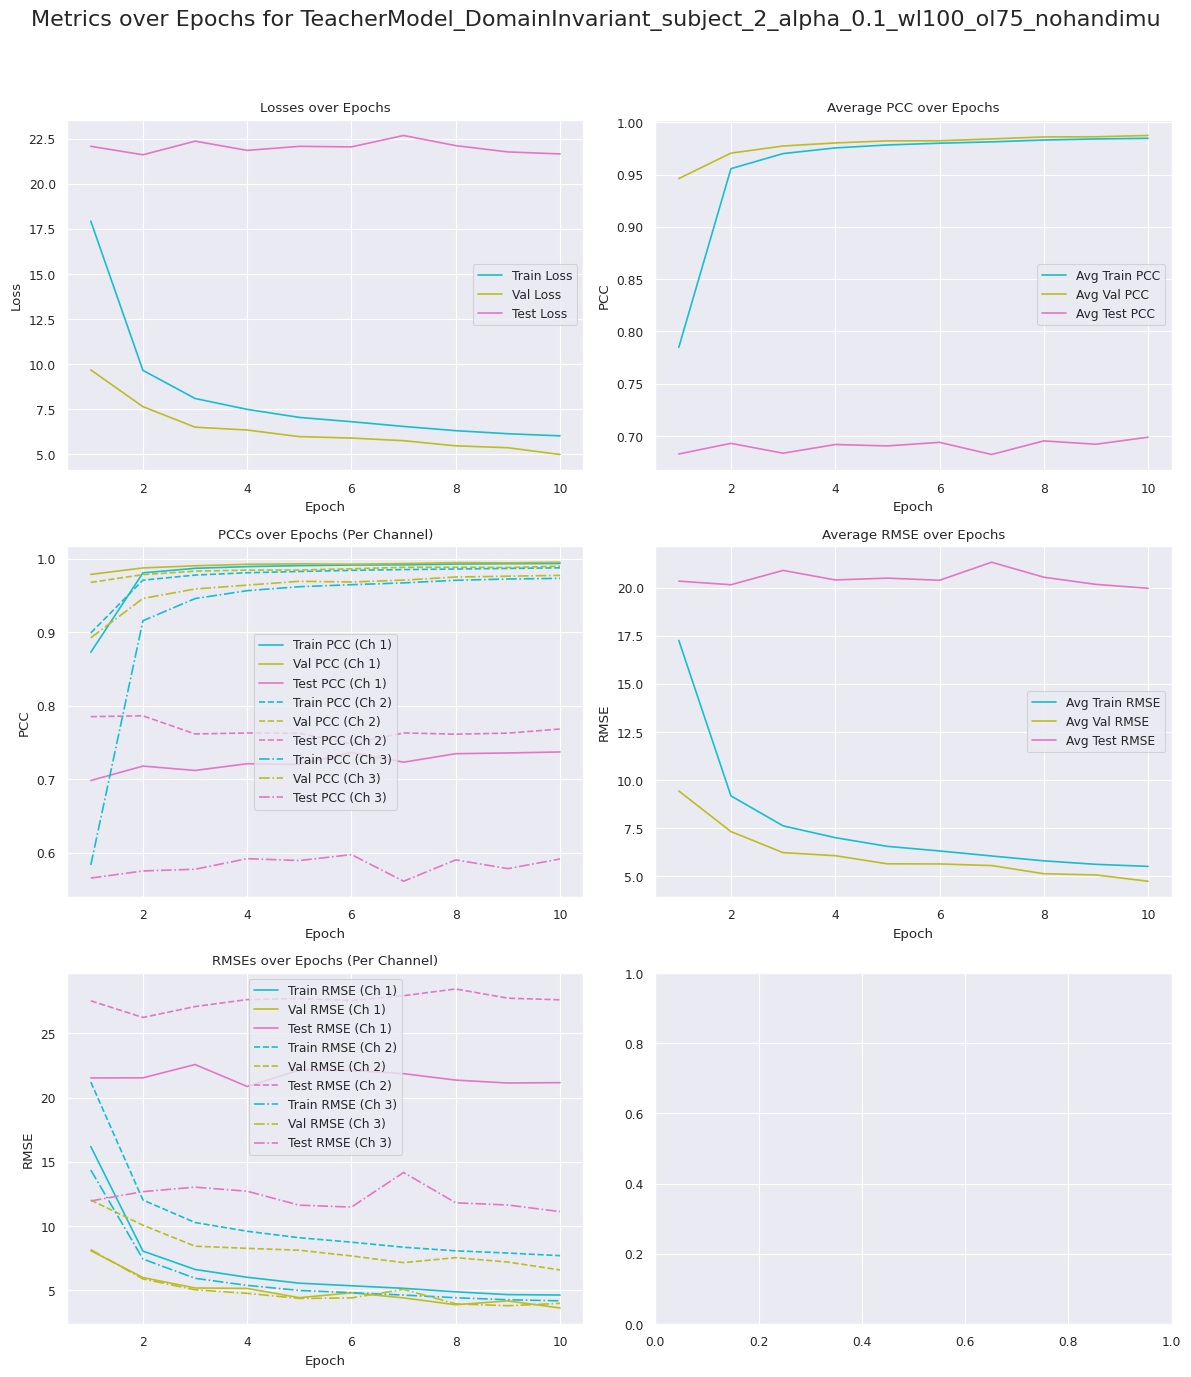

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_3_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_3_alpha_0.1_wl100_ol75_nohandimu


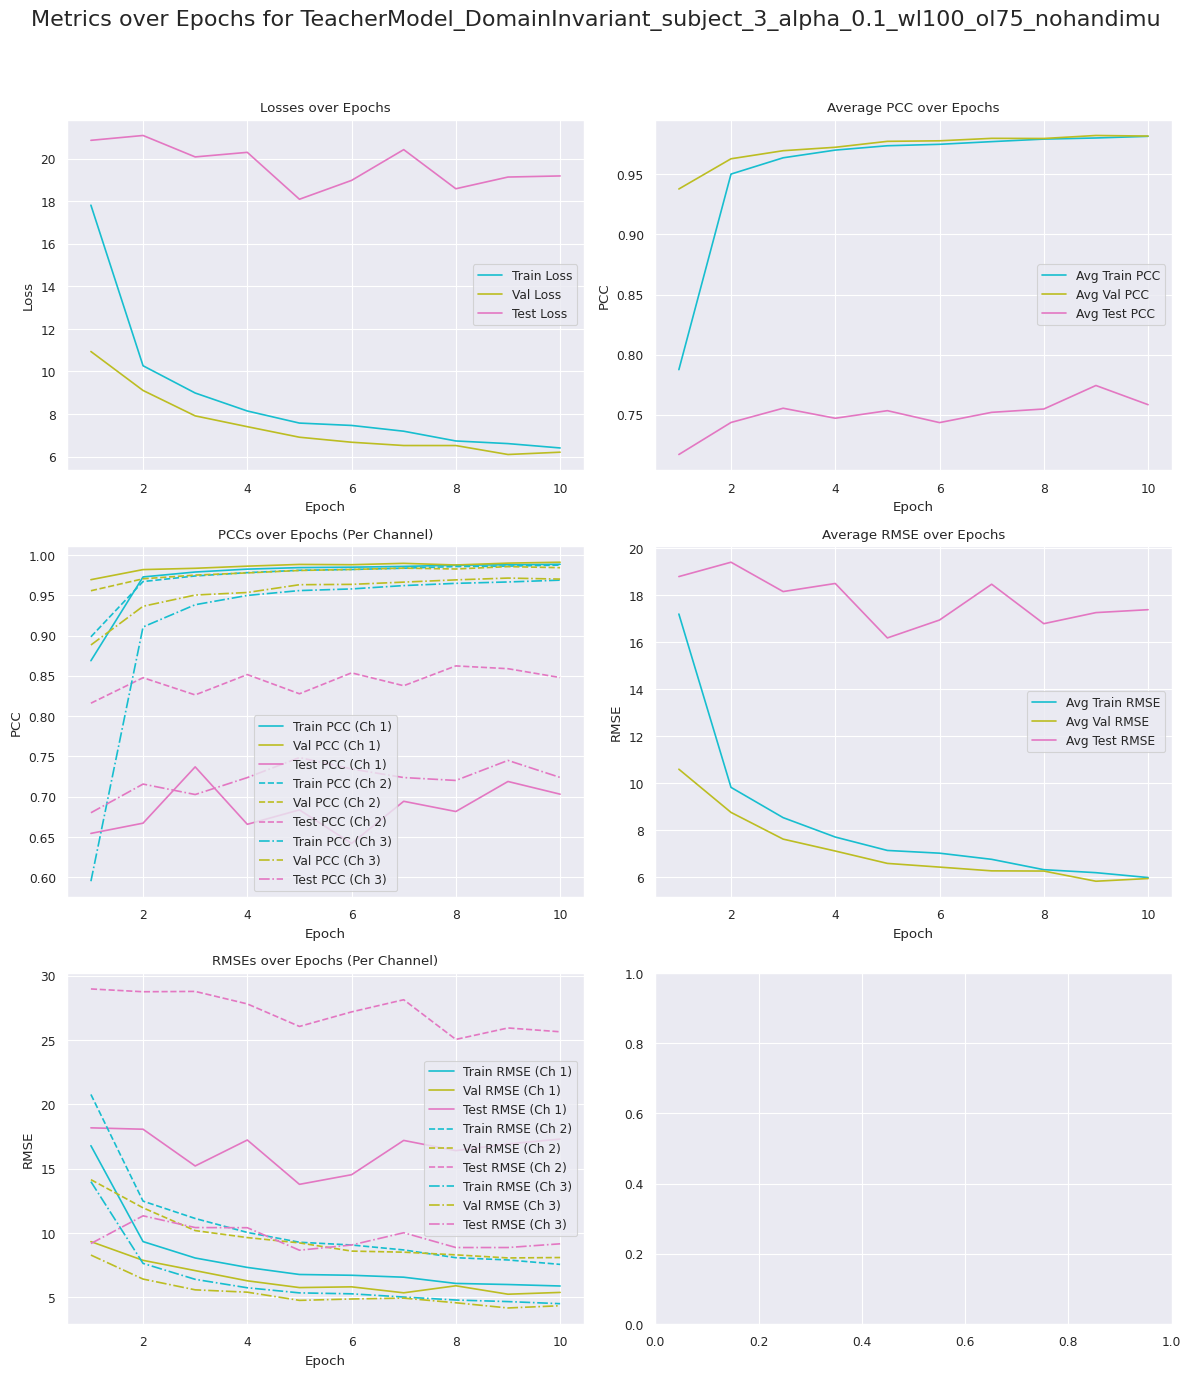

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_4_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_4_alpha_0.1_wl100_ol75_nohandimu


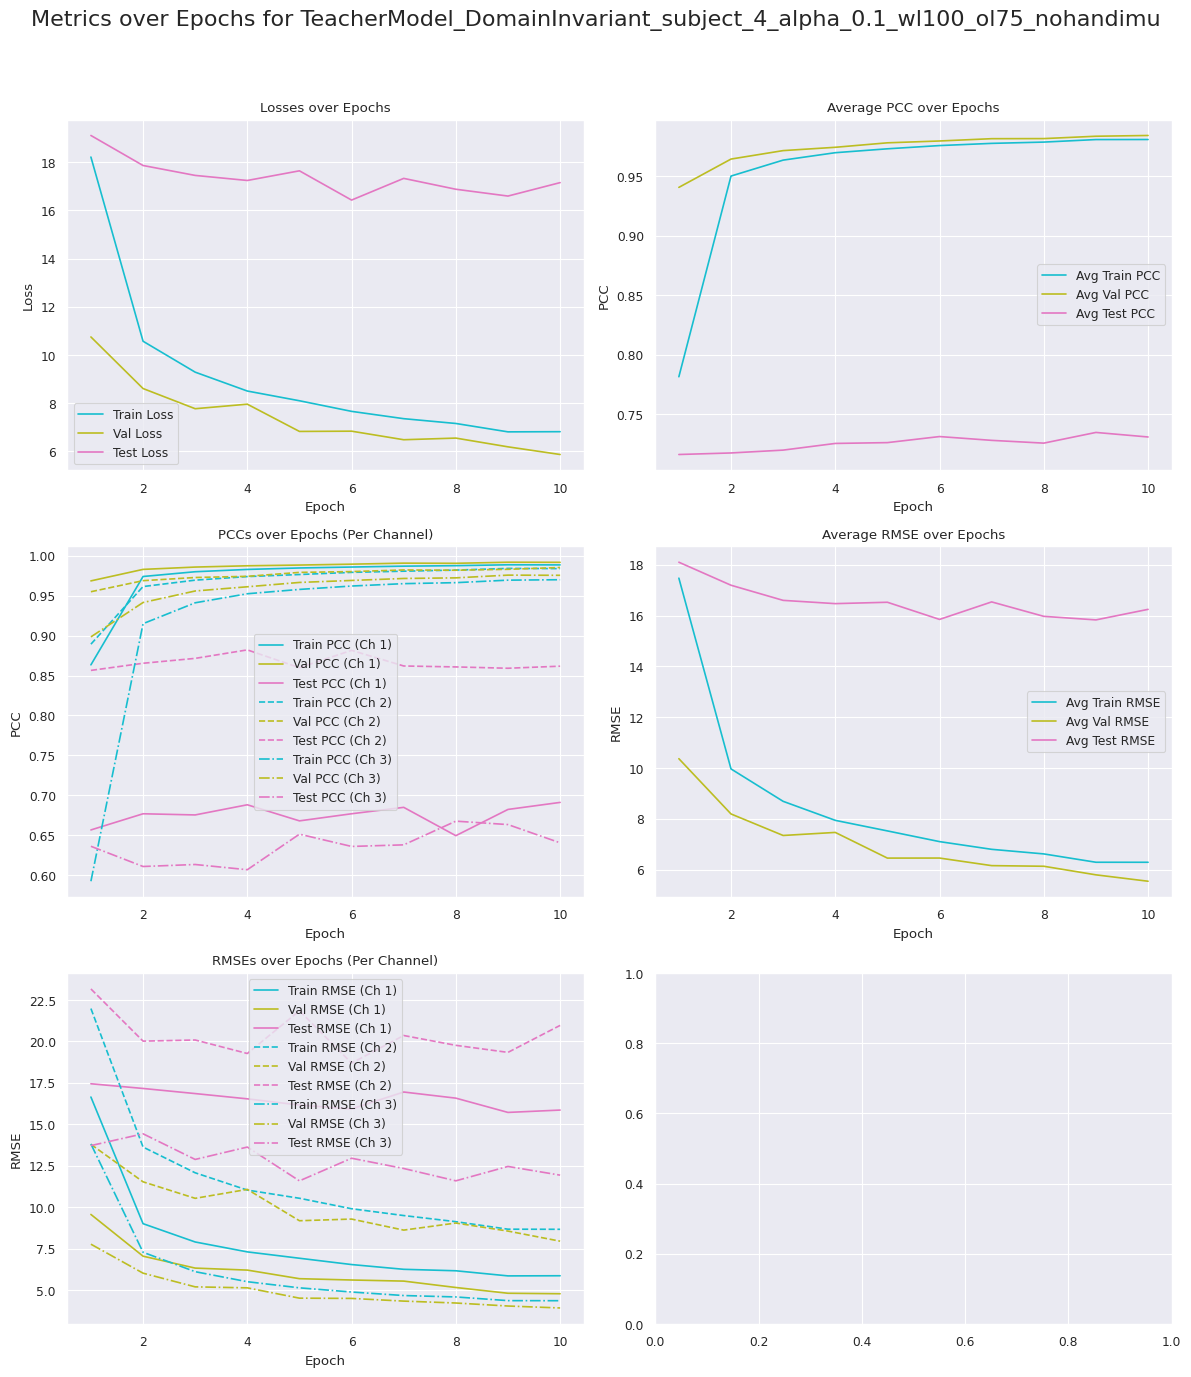

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_5_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_5_alpha_0.1_wl100_ol75_nohandimu


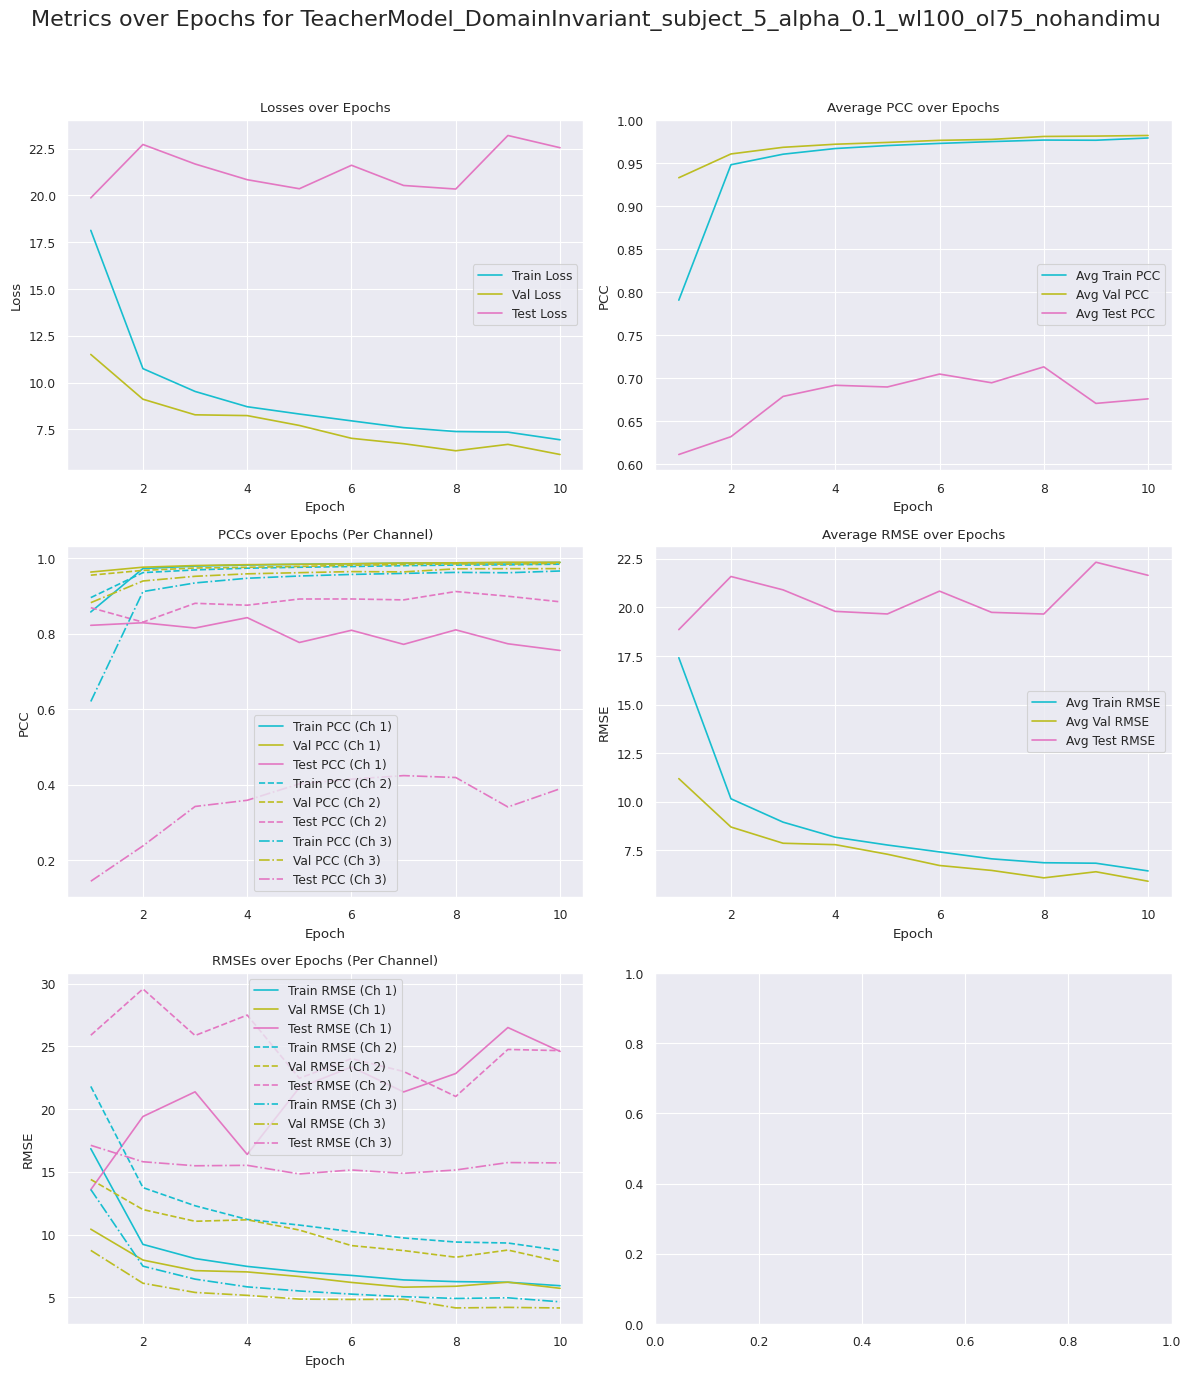

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_6_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_6_alpha_0.1_wl100_ol75_nohandimu


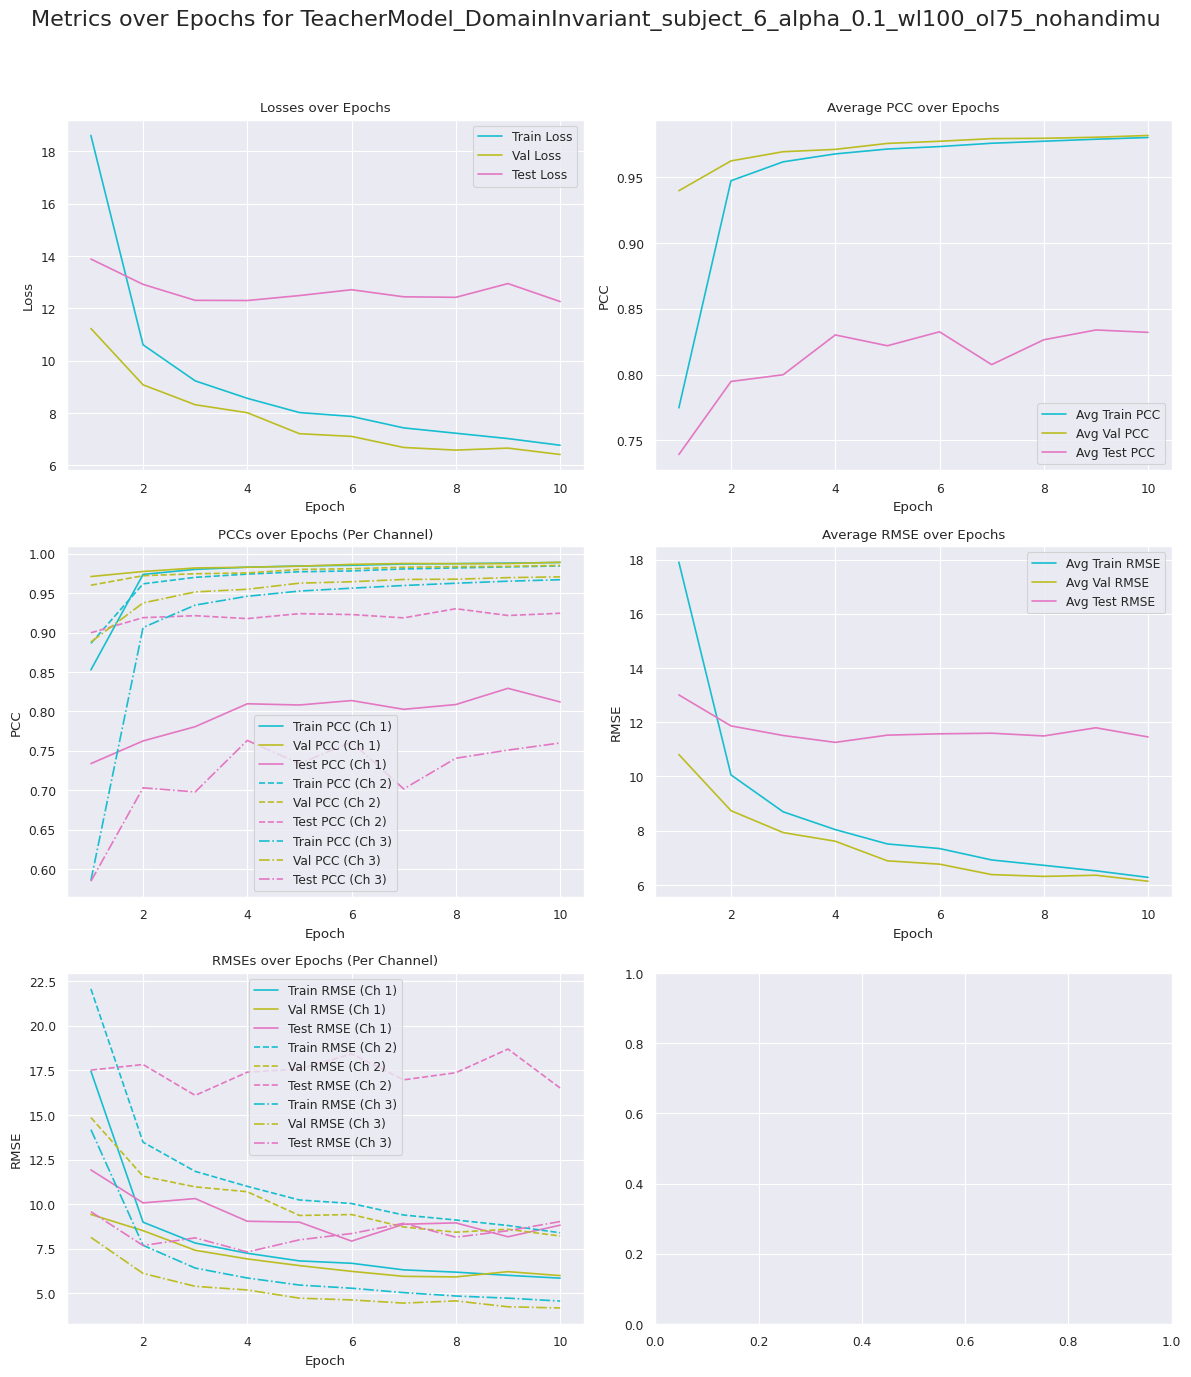

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_7_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_7_alpha_0.1_wl100_ol75_nohandimu


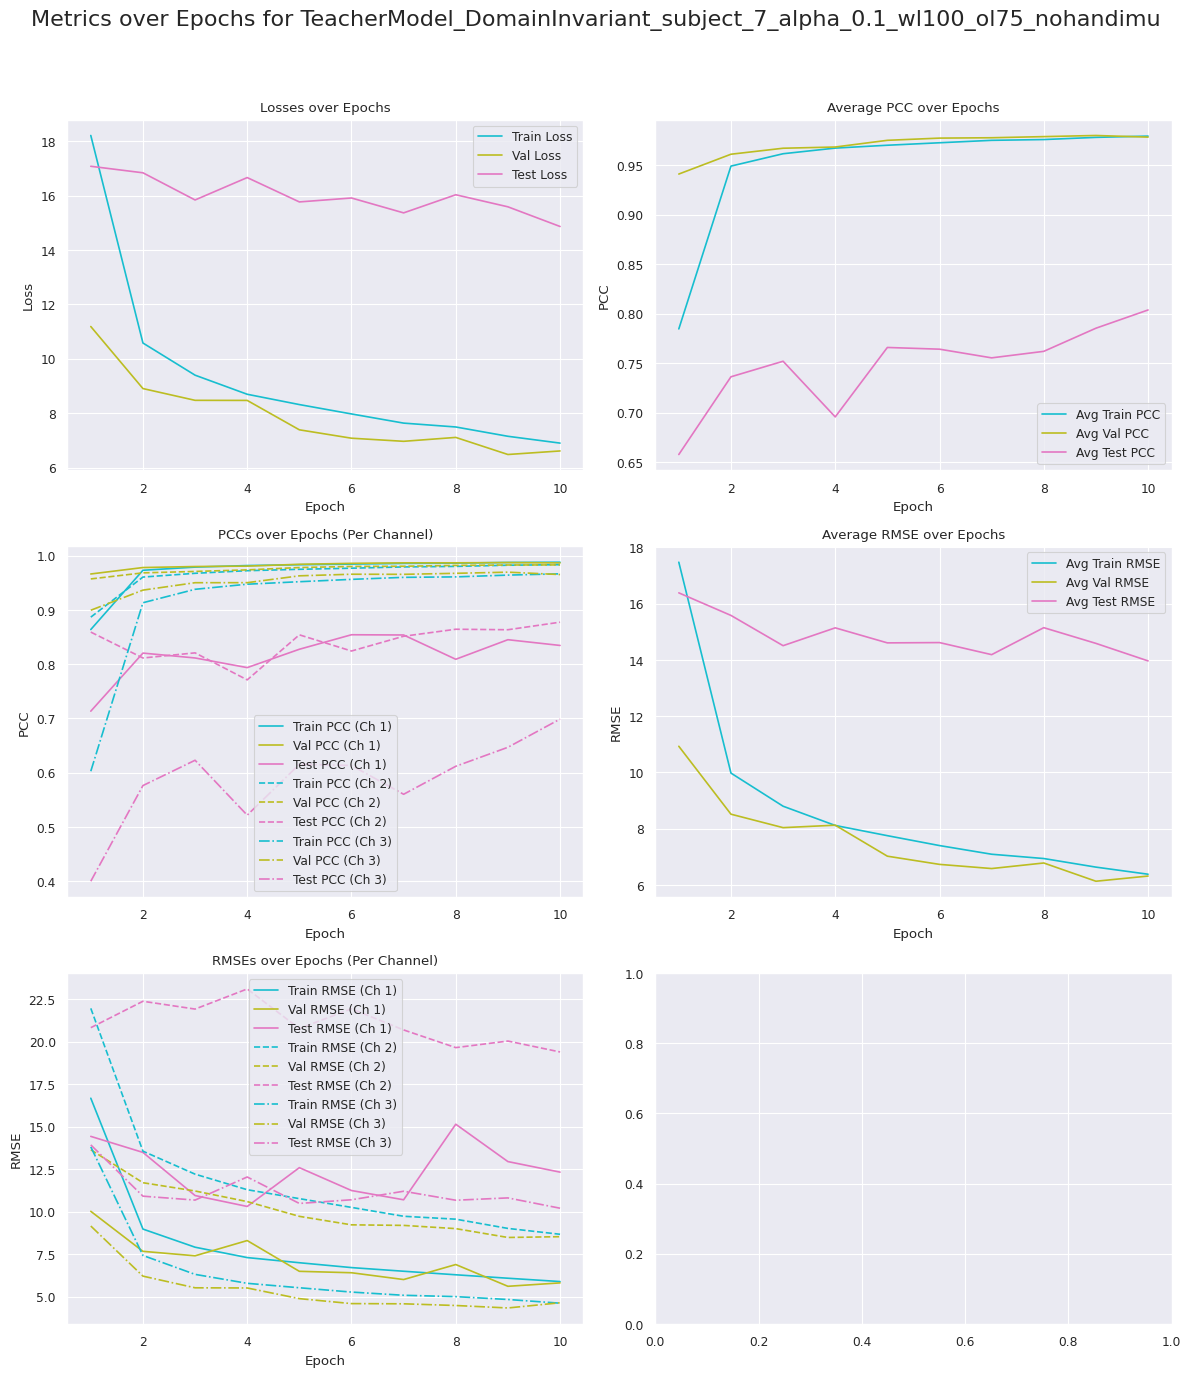

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_8_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_8_alpha_0.1_wl100_ol75_nohandimu


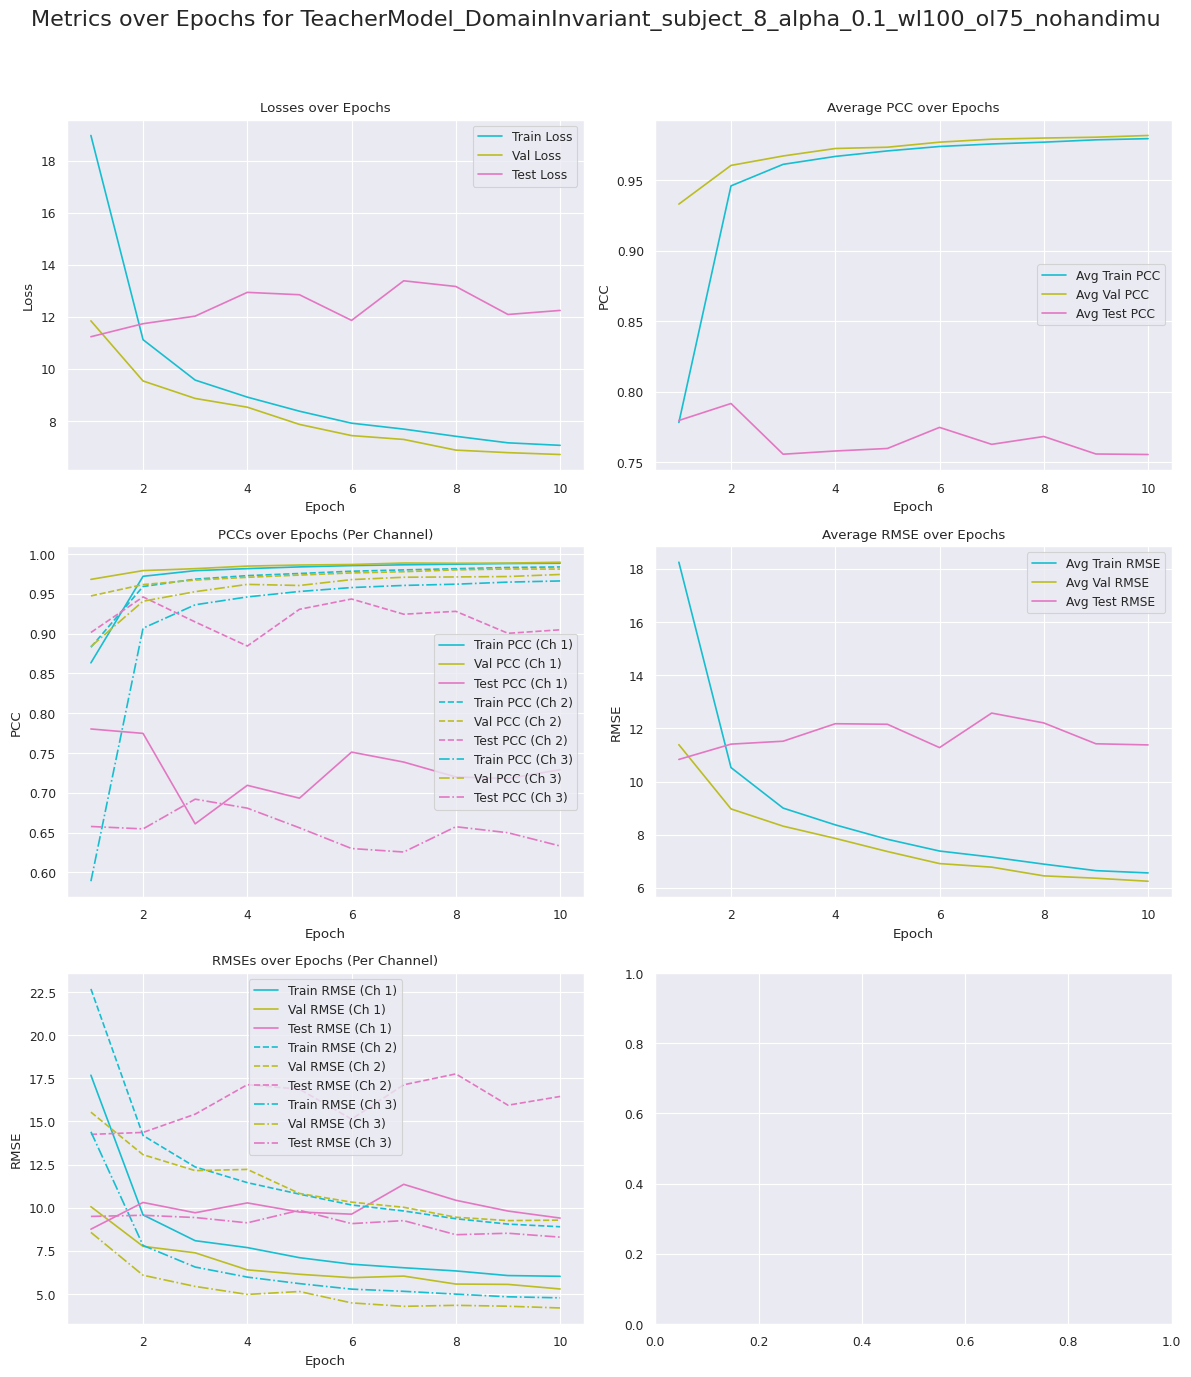

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_9_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_9_alpha_0.1_wl100_ol75_nohandimu


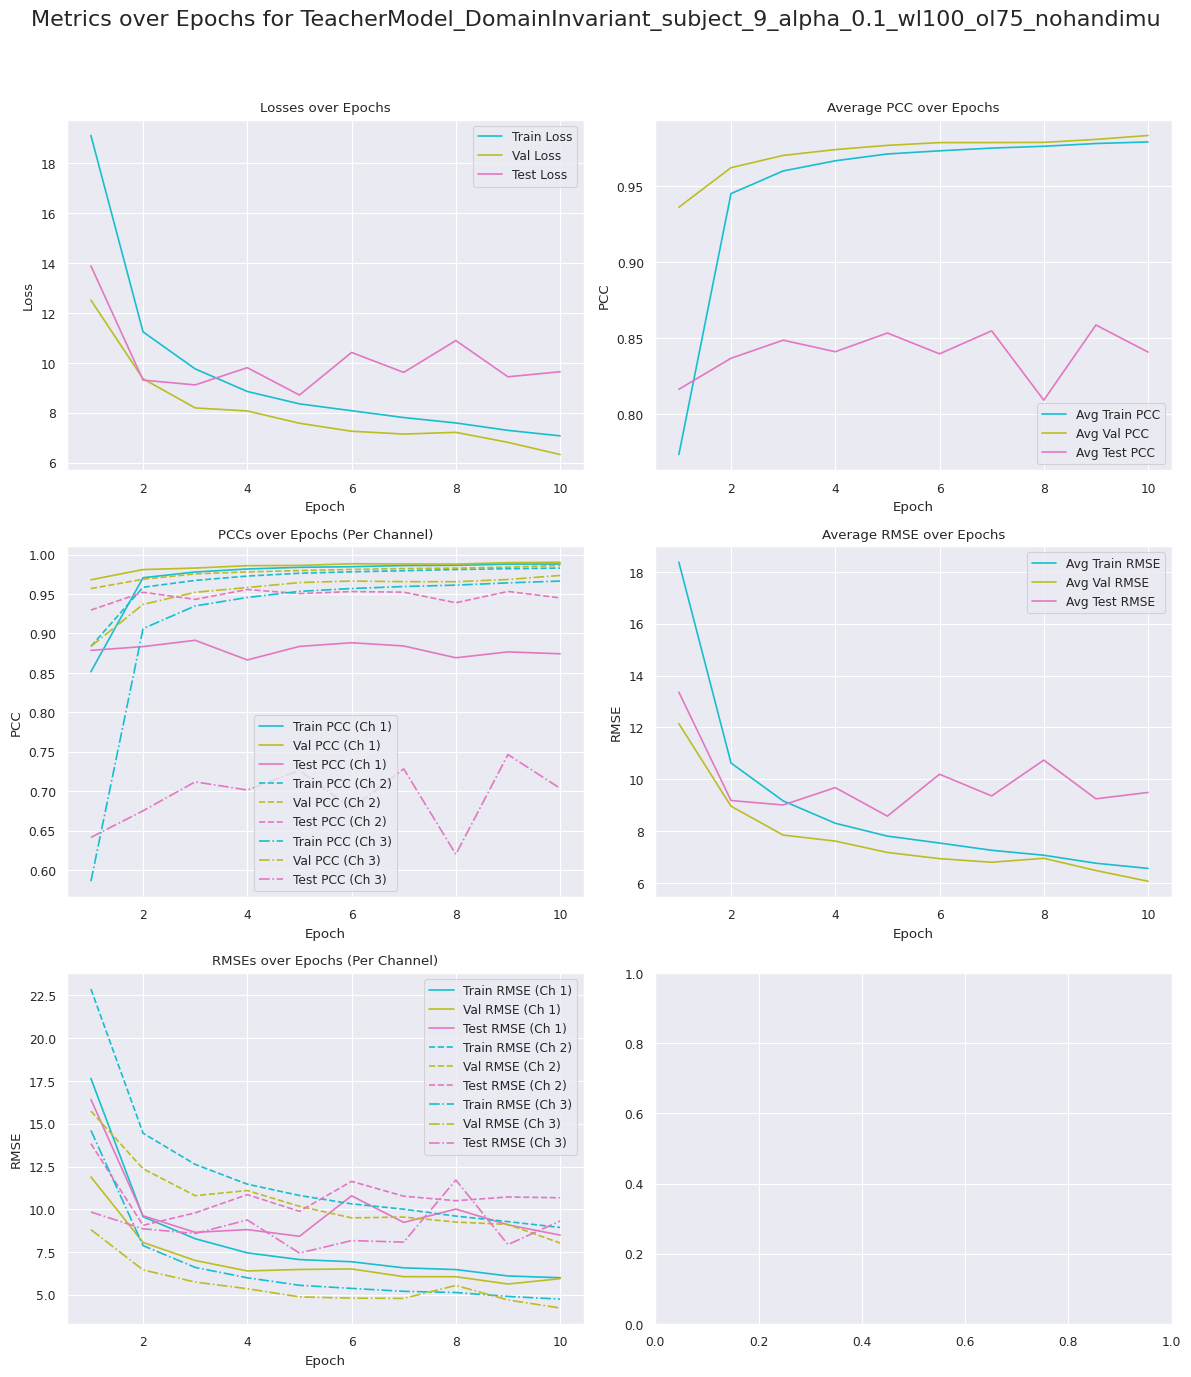

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_10_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_10_alpha_0.1_wl100_ol75_nohandimu


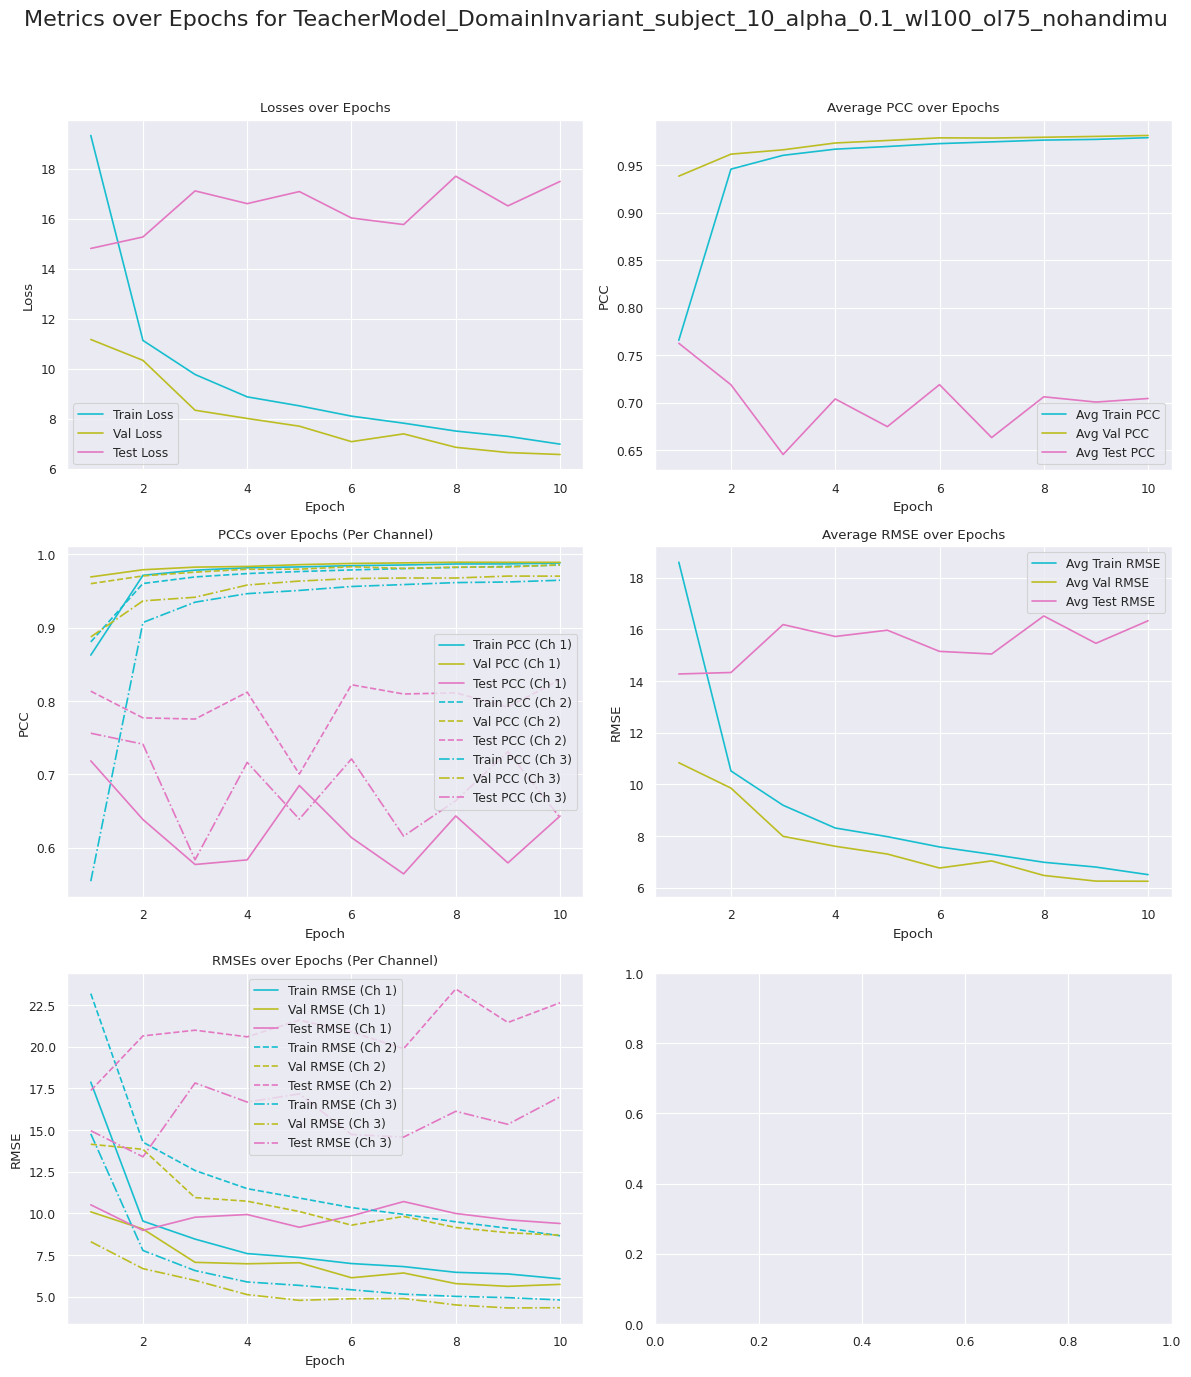

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_11_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_11_alpha_0.1_wl100_ol75_nohandimu


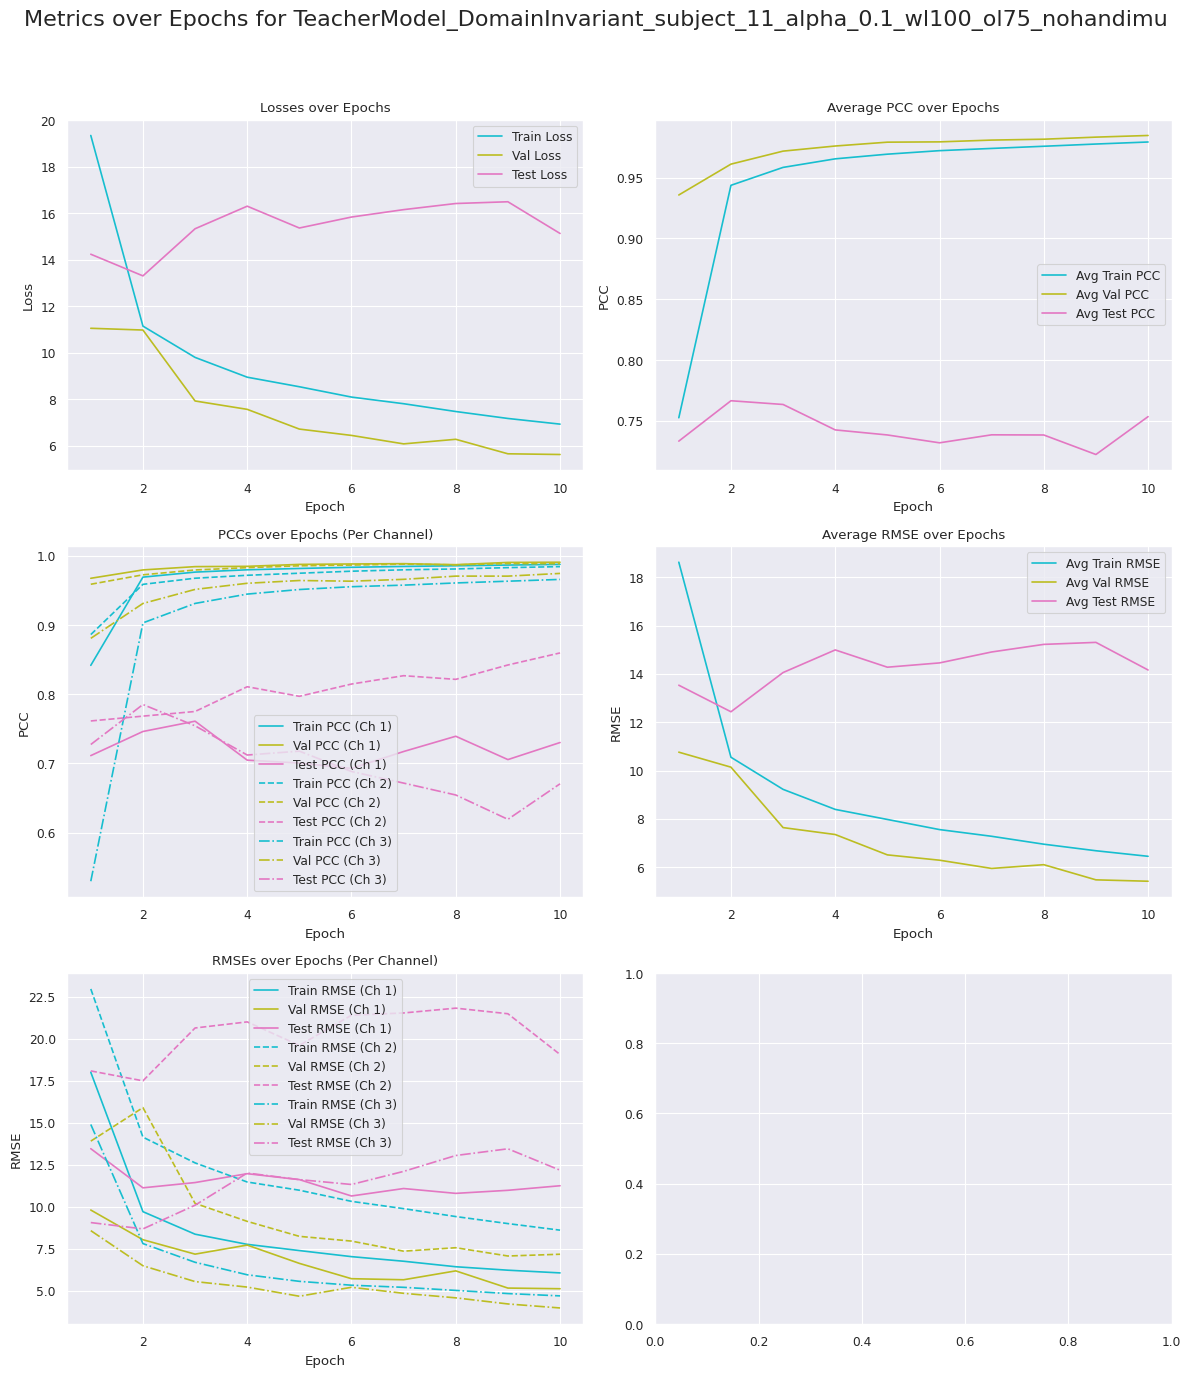

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_12_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_12_alpha_0.1_wl100_ol75_nohandimu


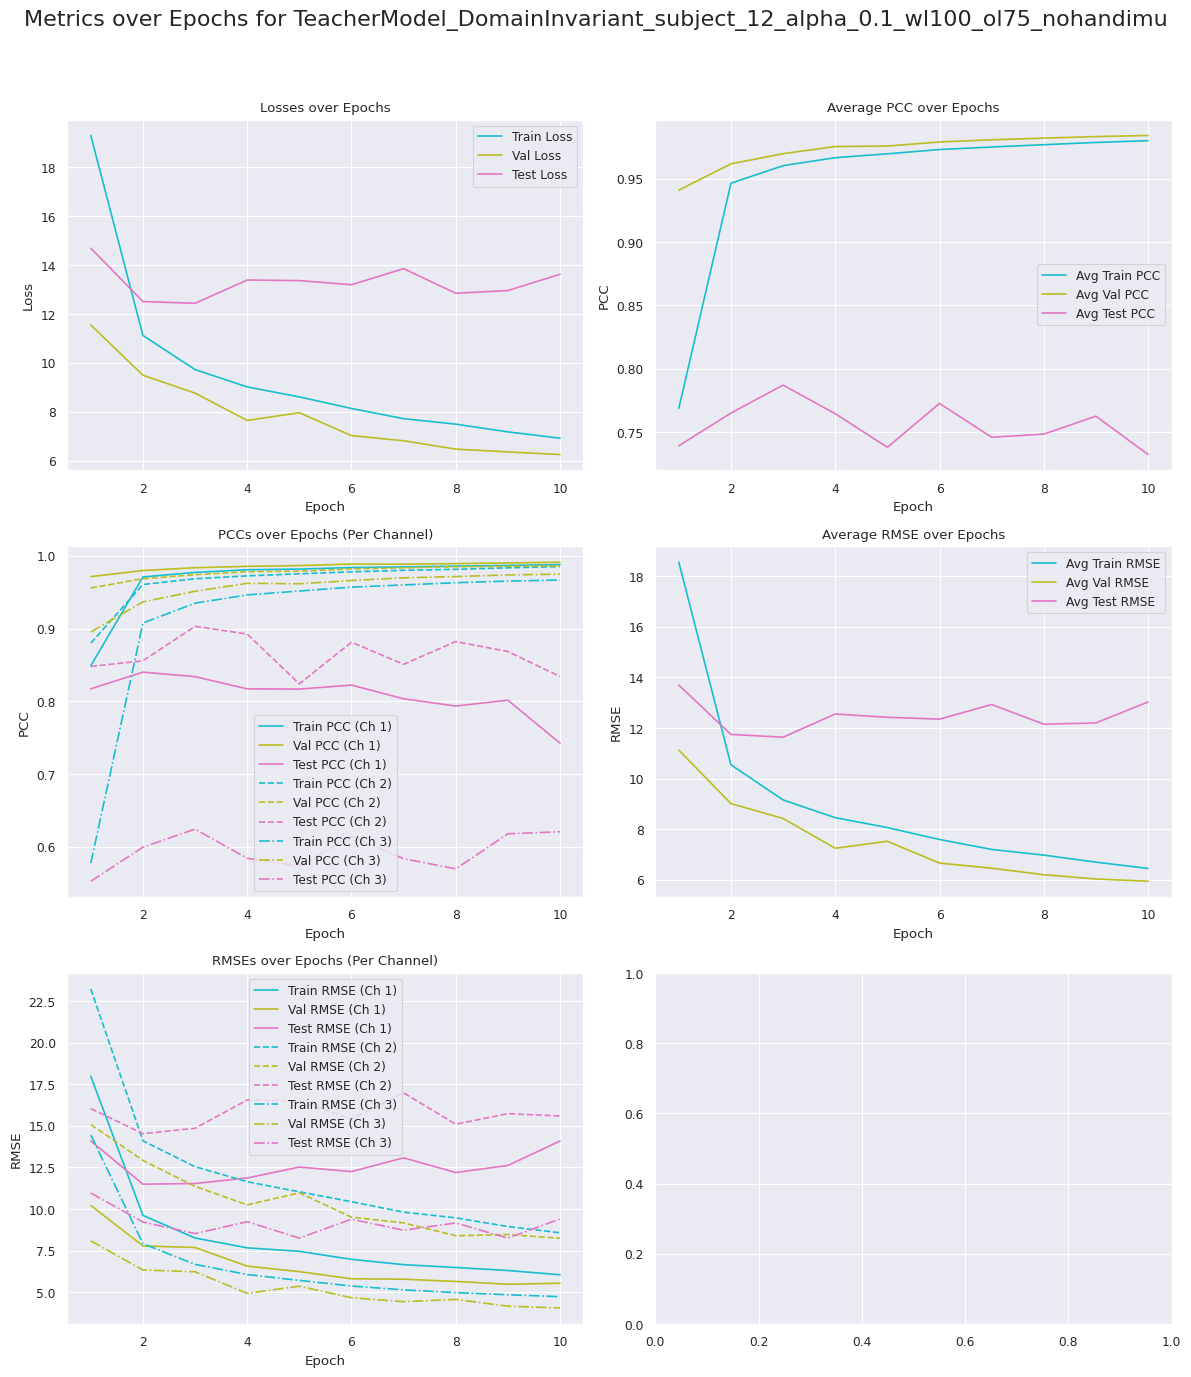

<ipython-input-11-c2a7bb3c0816>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint: TeacherModel_DomainInvariant_subject_13_alpha_0.1_wl100_ol75_nohandimu_epoch_10.pth from /content/MyDrive/MyDrive/models/TeacherModel_DomainInvariant_subject_13_alpha_0.1_wl100_ol75_nohandimu


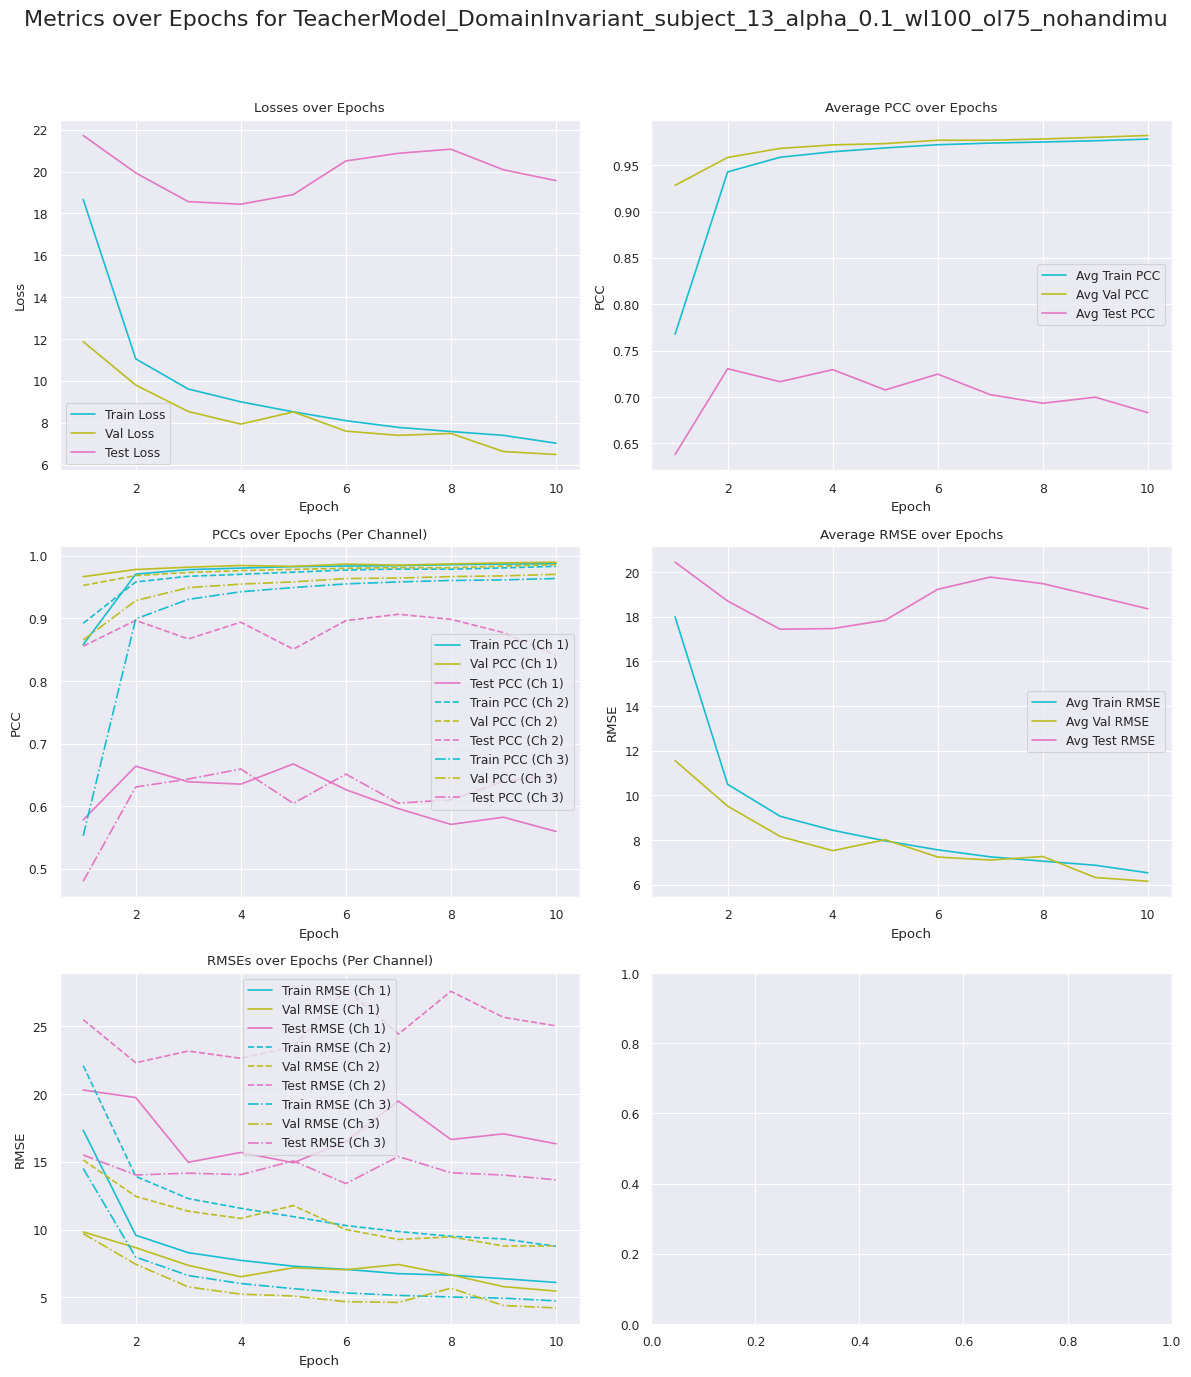

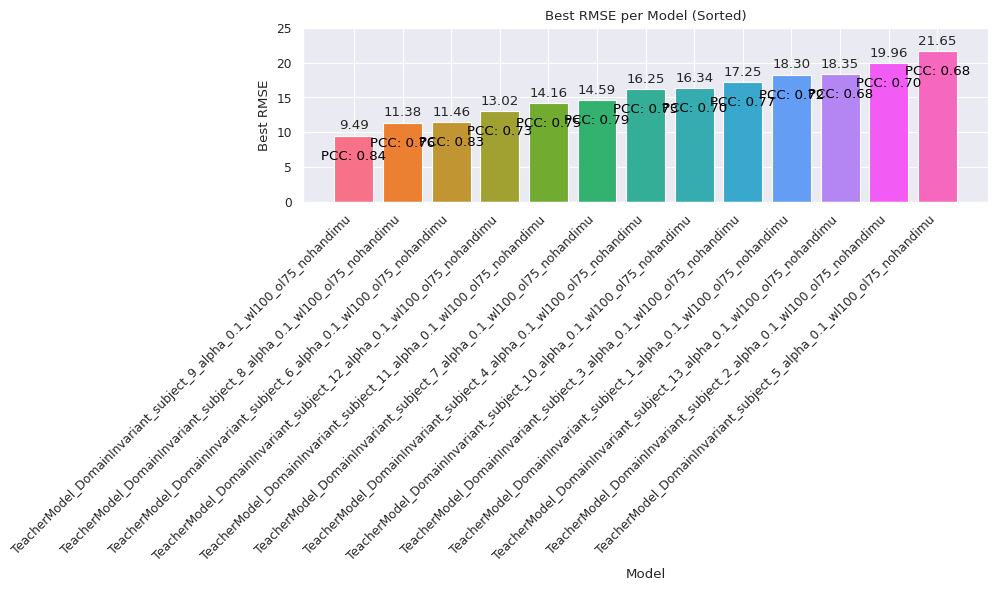

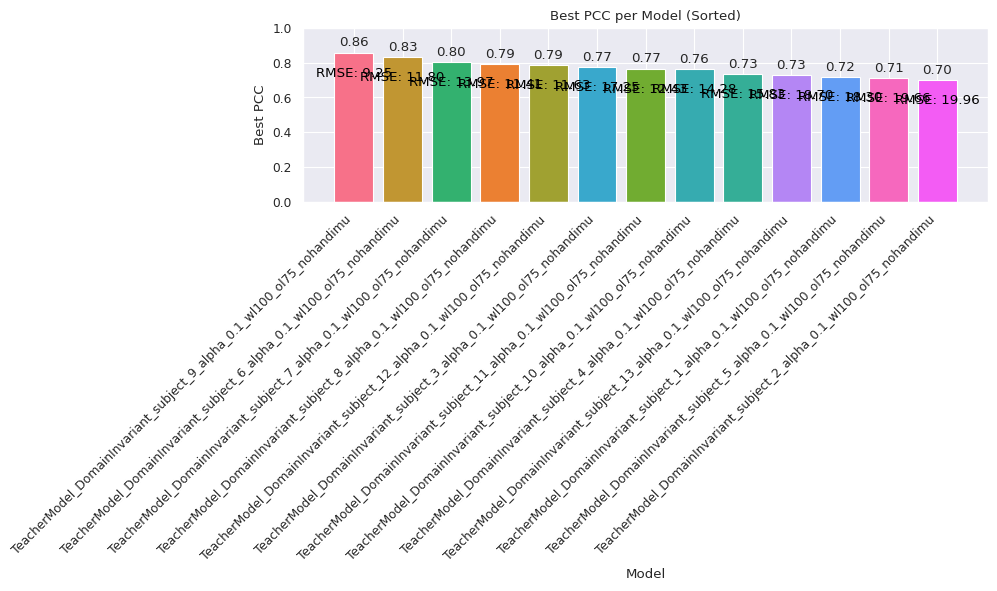

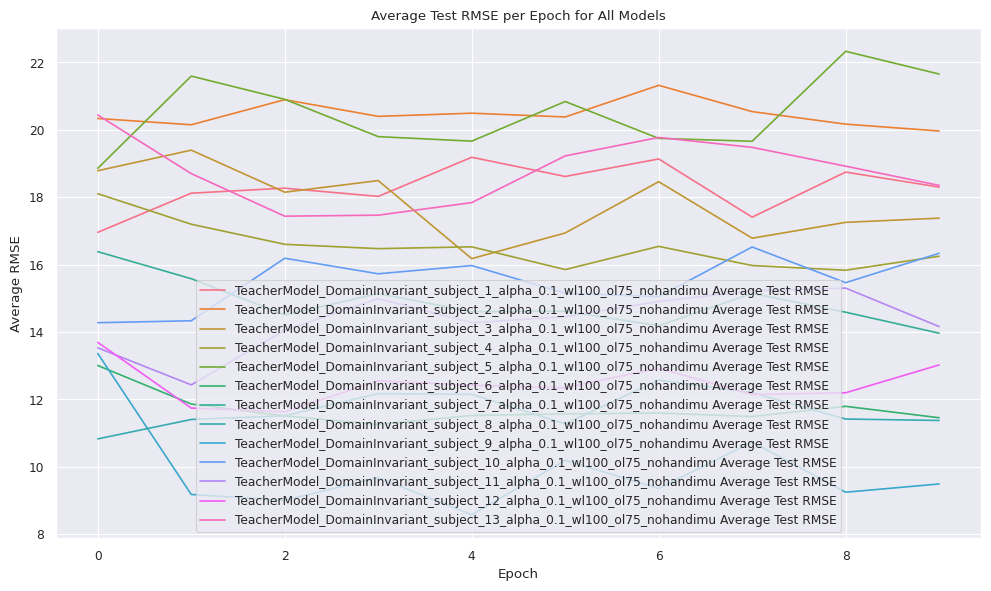

In [11]:
# @title Plotting
import matplotlib.pyplot as plt
def load_most_recent_checkpoint(folder):
    """
    Loads the most recent checkpoint from the given folder and returns it.
    """
    checkpoint_files = [f for f in os.listdir(folder) if f.endswith('.pth')]
    if not checkpoint_files:
        print(f"No checkpoints found in {folder}")
        return None

    # Sort the checkpoint files by epoch (assuming filenames include the epoch number)
    checkpoint_files.sort(key=lambda f: int(f.split('_epoch_')[-1].split('.')[0]))

    # Load the most recent checkpoint
    latest_checkpoint = checkpoint_files[-1]
    checkpoint_path = os.path.join(folder, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)

    print(f"Loaded checkpoint: {latest_checkpoint} from {folder}")

    # Return the loaded checkpoint, which contains model state, optimizer state, and history
    return checkpoint

def plot_metrics_subplots(aggregated_metrics, folder):
    """Plots train/val/test losses, PCCs, and RMSEs in subplots."""
    epochs = list(range(1, len(aggregated_metrics['train_losses']) + 1))
    line_styles = ['-', '--', '-.', ':']  # Define different line styles for channels

    # New color palette
    train_color = '#17becf'  # Teal blue for Train
    val_color = '#bcbd22'    # Mustard yellow for Val
    test_color = '#e377c2'   # Pastel magenta for Test

    # Create subplots for losses, PCCs, and RMSEs
    fig, axes = plt.subplots(3, 2, figsize=(12, 14))
    fig.suptitle(f'Metrics over Epochs for {folder}', fontsize=16)

    # Plot Losses (subplot 1, 1)
    axes[0, 0].plot(epochs, aggregated_metrics['train_losses'], label='Train Loss', color=train_color, linestyle=line_styles[0])
    axes[0, 0].plot(epochs, aggregated_metrics['val_losses'], label='Val Loss', color=val_color, linestyle=line_styles[0])
    axes[0, 0].plot(epochs, aggregated_metrics['test_losses'], label='Test Loss', color=test_color, linestyle=line_styles[0])
    axes[0, 0].set_title('Losses over Epochs')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot Average PCCs (already averaged, so no need to take mean again) (subplot 1, 2)
    axes[0, 1].plot(epochs, aggregated_metrics['train_pccs'], label='Avg Train PCC', color=train_color, linestyle='-')
    axes[0, 1].plot(epochs, aggregated_metrics['val_pccs'], label='Avg Val PCC', color=val_color, linestyle='-')
    axes[0, 1].plot(epochs, aggregated_metrics['test_pccs'], label='Avg Test PCC', color=test_color, linestyle='-')
    axes[0, 1].set_title('Average PCC over Epochs')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('PCC')
    axes[0, 1].legend()

    # Plot PCCs for each channel (subplot 2, 1)
    for i, style in enumerate(line_styles):
        if len(aggregated_metrics['train_pccs_channelwise'][0]) > i:  # Ensure enough channels exist
            axes[1, 0].plot(epochs, [pcc[i] for pcc in aggregated_metrics['train_pccs_channelwise']], label=f'Train PCC (Ch {i+1})', color=train_color, linestyle=style)
            axes[1, 0].plot(epochs, [pcc[i] for pcc in aggregated_metrics['val_pccs_channelwise']], label=f'Val PCC (Ch {i+1})', color=val_color, linestyle=style)
            axes[1, 0].plot(epochs, [pcc[i] for pcc in aggregated_metrics['test_pccs_channelwise']], label=f'Test PCC (Ch {i+1})', color=test_color, linestyle=style)
    axes[1, 0].set_title('PCCs over Epochs (Per Channel)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('PCC')
    axes[1, 0].legend()

    # Plot Average RMSEs (already averaged, so no need to take mean again) (subplot 2, 2)
    axes[1, 1].plot(epochs, aggregated_metrics['train_rmses'], label='Avg Train RMSE', color=train_color, linestyle='-')
    axes[1, 1].plot(epochs, aggregated_metrics['val_rmses'], label='Avg Val RMSE', color=val_color, linestyle='-')
    axes[1, 1].plot(epochs, aggregated_metrics['test_rmses'], label='Avg Test RMSE', color=test_color, linestyle='-')
    axes[1, 1].set_title('Average RMSE over Epochs')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].legend()

    # Plot RMSEs for each channel (subplot 3, 1)
    for i, style in enumerate(line_styles):
        if len(aggregated_metrics['train_rmses_channelwise'][0]) > i:
            axes[2, 0].plot(epochs, [rmse[i] for rmse in aggregated_metrics['train_rmses_channelwise']], label=f'Train RMSE (Ch {i+1})', color=train_color, linestyle=style)
            axes[2, 0].plot(epochs, [rmse[i] for rmse in aggregated_metrics['val_rmses_channelwise']], label=f'Val RMSE (Ch {i+1})', color=val_color, linestyle=style)
            axes[2, 0].plot(epochs, [rmse[i] for rmse in aggregated_metrics['test_rmses_channelwise']], label=f'Test RMSE (Ch {i+1})', color=test_color, linestyle=style)
    axes[2, 0].set_title('RMSEs over Epochs (Per Channel)')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('RMSE')
    axes[2, 0].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

def plot_comparison_bar_graphs_with_limits(aggregated_metrics_dict):
    """
    Plots two bar graphs comparing the best RMSE and PCC for each model, showing corresponding PCC/RMSE from the same epoch,
    and plots average test RMSEs across epochs for each model.
    """

    # Dictionary to hold the best RMSE and PCC along with their associated metrics at the same epoch
    best_metrics = {}

    # Iterate through the aggregated metrics and extract the best RMSE and its corresponding PCC, and vice versa
    for model_name, metrics in aggregated_metrics_dict.items():
        # Extract pre-averaged RMSEs and PCCs for the test data
        test_rmses = metrics['test_rmses']  # Pre-averaged RMSE values
        test_pccs = metrics['test_pccs']    # Pre-averaged PCC values
        val_losses = metrics['val_losses']  # Pre-averaged validation losses

        # Find the epoch index for the best RMSE and the corresponding PCC at that epoch
        best_rmse_epoch = np.argmin(val_losses)
        best_rmse = test_rmses[best_rmse_epoch]
        corresponding_pcc_for_best_rmse = test_pccs[best_rmse_epoch]

        # Find the epoch index for the best PCC and the corresponding RMSE at that epoch
        best_pcc_epoch = np.argmax(test_pccs)
        best_pcc = test_pccs[best_pcc_epoch]
        corresponding_rmse_for_best_pcc = test_rmses[best_pcc_epoch]

        # Store in a dictionary for plotting
        best_metrics[model_name] = {
            'best_rmse': best_rmse,
            'corresponding_pcc_for_best_rmse': corresponding_pcc_for_best_rmse,
            'best_pcc': best_pcc,
            'corresponding_rmse_for_best_pcc': corresponding_rmse_for_best_pcc
        }

    # Convert to lists for sorting
    models = list(best_metrics.keys())
    best_rmses = [best_metrics[model]['best_rmse'] for model in models]
    corresponding_pccs = [best_metrics[model]['corresponding_pcc_for_best_rmse'] for model in models]
    best_pccs = [best_metrics[model]['best_pcc'] for model in models]
    corresponding_rmses = [best_metrics[model]['corresponding_rmse_for_best_pcc'] for model in models]

    # Sort by RMSE and PCC
    sorted_by_rmse = sorted(zip(models, best_rmses, corresponding_pccs), key=lambda x: x[1], reverse=False)
    sorted_by_pcc = sorted(zip(models, best_pccs, corresponding_rmses), key=lambda x: x[1], reverse=True)

    # Unpack sorted values
    sorted_models_rmse, sorted_rmses, sorted_pccs_for_rmse = zip(*sorted_by_rmse)
    sorted_models_pcc, sorted_pccs, sorted_rmses_for_pcc = zip(*sorted_by_pcc)

    # Ensure consistent colors across both graphs
    colors = sns.color_palette("husl", len(models))
    model_colors_rmse = {model: colors[i] for i, model in enumerate(sorted_models_rmse)}
    model_colors_pcc = {model: model_colors_rmse[model] for model in sorted_models_pcc}  # Keep the colors consistent

    # Plot RMSE Bar Graph (With Corresponding PCC values)
    plt.figure(figsize=(10, 6))
    bars_rmse = plt.bar(sorted_models_rmse, sorted_rmses, color=[model_colors_rmse[model] for model in sorted_models_rmse])
    plt.title('Best RMSE per Model (Sorted)')
    plt.xlabel('Model')
    plt.ylabel('Best RMSE')
    plt.ylim(0, 25)  # Set an appropriate y-limit for RMSEs
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add the actual RMSE values and corresponding PCC on top of the bars
    for i, bar in enumerate(bars_rmse):
        yval_rmse = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval_rmse + 0.5, f'{yval_rmse:.2f}', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width()/2, yval_rmse - 2, f'PCC: {sorted_pccs_for_rmse[i]:.2f}', ha='center', va='top', color='black')

    plt.show()

    # Plot PCC Bar Graph (With Corresponding RMSE values)
    plt.figure(figsize=(10, 6))
    bars_pcc = plt.bar(sorted_models_pcc, sorted_pccs, color=[model_colors_pcc[model] for model in sorted_models_pcc])
    plt.title('Best PCC per Model (Sorted)')
    plt.xlabel('Model')
    plt.ylabel('Best PCC')
    plt.ylim(0, 1)  # Set an appropriate y-limit for PCCs
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add the actual PCC values and corresponding RMSE on top of the bars
    for i, bar in enumerate(bars_pcc):
        yval_pcc = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval_pcc + 0.02, f'{yval_pcc:.2f}', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width()/2, yval_pcc - 0.08, f'RMSE: {sorted_rmses_for_pcc[i]:.2f}', ha='center', va='top', color='black')

    plt.show()

    # Plot the average test RMSEs across epochs for each model
    plt.figure(figsize=(10, 6))
    for i, model in enumerate(models):
        avg_test_rmses = aggregated_metrics_dict[model]['test_rmses']  # Directly plot pre-averaged RMSEs
        plt.plot(avg_test_rmses, label=f'{model} Average Test RMSE', color=colors[i])

    plt.title('Average Test RMSE per Epoch for All Models')
    plt.xlabel('Epoch')
    plt.ylabel('Average RMSE')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Initialize an empty dictionary to hold metrics for all models
aggregated_metrics_dict = {}

# Loop over each model and load the checkpoint
for model_name, model_config in model_configs.items():
    # Construct the folder path based on the filename
    folder = f"/content/MyDrive/MyDrive/models/{model_name}"
    checkpoint = load_most_recent_checkpoint(folder)

    if checkpoint:
        aggregated_metrics = checkpoint['history']

        # Store the metrics for comparison later
        aggregated_metrics_dict[model_name] = {
            'test_rmses': aggregated_metrics['test_rmses'],
            'test_pccs': aggregated_metrics['test_pccs'],
            'train_losses': aggregated_metrics['train_losses'],
            'val_losses': aggregated_metrics['val_losses'],
        }

        # Plot metrics for this model
        plot_metrics_subplots(aggregated_metrics, model_name)

# After collecting all model metrics, plot the comparison bar graphs
if aggregated_metrics_dict:
    plot_comparison_bar_graphs_with_limits(aggregated_metrics_dict)
